# Data Manipulation

> Author: *Valentin Christiaens* (core Nb), *Dominique Sluse*   
> Package dependencies: astropy, astroquery, matplotlib, numpy, pandas
> 
> Some useful tool complimentary to this Nb: 
> - TOPCAT: [https://www.star.bris.ac.uk/~mbt/topcat/](https://www.star.bris.ac.uk/~mbt/topcat/)
> - Aladin Desktop: [https://aladin.cds.unistra.fr/java/nph-aladin.pl?frame=downloading](https://aladin.cds.unistra.fr/java/nph-aladin.pl?frame=downloading) 
> - DS9: [https://sites.google.com/cfa.harvard.edu/saoimageds9](https://sites.google.com/cfa.harvard.edu/saoimageds9)
>
> The data needed for this Nb should be downloaded separately along this link: [https://dox.uliege.be/index.php/s/rVCiGqm6oCQV4Pd](https://dox.uliege.be/index.php/s/rVCiGqm6oCQV4Pd)
> The data should be moved into the sub-directory `data` (i.e. child directory of the folder hosting this Nb) 
> 
> Last update: *2026/01/30*

---

## Table of contents

* [1. Data Format](#1.-Data-Format)
    - [1.1. Overview](#1.1.-Overview)
    - [1.2. Units and quantities](#1.2.-Units-and-quantities)
    - [1.3. Astrophysical constants](#1.3.-Astrophysical-constants)
* [2. Querying online data](#2.-Querying-online-data)
    - [2.1. Querying SIMBAD](#2.1.-Querying-SIMBAD)
    - [2.2. Loading archival data](#2.2.-Loading-archival-data)
    - [2.3. Retrieving data from a Vizier catalog](#2.3.-Retrieving-data-from-a-Vizier-catalog)
* [3. Manipulating FITS files](#3.-Manipulating-FITS-files)
    - [3.1. Basic operations on FITS files](#3.1.-Basic-operations-on-FITS-files)
    - [3.2. Editing FITS images and headers](#3.2.-Editing-FITS-images-and-headers)
    - [3.3. FITS Tables](#3.3.-FITS-Tables)
* [4. Astropy Tables](#4.-Astropy-Tables)
    - [4.1. Reading a Table](#4.1.-Reading-a-Table)
    - [4.2. Constructing, modifying and writing a Table](#4.2.-Constructing,-modifying-and-writing-a-Table)
    - [4.3. Table operations](#4.3.-Table-operations)
    - [4.4. Comparison with Pandas DataFrames](#4.4.-Comparison-with-Pandas-DataFrames)
* [5. Coordinates](#5.-Coordinates)
    - [5.1. Overlaying image coordinates](#5.1.-Overlaying-image-coordinates)
    - [5.2. Basic operations with coordinates](#5.2.-Basic-operations-with-coordinates)
    - [5.3. Conversion between image and world coordinates](#5.3.-Conversion-between-image-and-world-coordinates)
    - [5.4. Spherical projections](#5.4.-Spherical-projections)
    - [5.5. Scale marker](#5.5.-Scale-marker) 
    - [5.6. 3D sky coordinates](#5.6.-3D-sky-coordinates) 

---

Before being able to do regressions or apply machine learning tools on your data, you first need the data!
You need to be able to fetch them, load them, and parse them in order to interpret them.

The data can come in a wide variety of formats. In this lecture, we will see the different tools you can use to:
- fetch astronomical data or catalogs online,
- load and manipulate FITS images and spectral cubes of images,
- load and manipulate FITS tables and other datasets in tabular format,
- derive the astronomical coordinates of the pixels in your images, and project the data onto different coordinate systems.

**Goals of this lecture:** 

1. Know how to manipulate Astropy `Quantity` objects.
2. Be able to retrieve data from online databases, archives or catalogs using `astroquery`;
3. Know how to read, manipulate, edit, and write FITS files (incl. header) using `astropy`;
4. Be familiar with astropy `coordinate` systems;
5. Know how to perform basic operations on Astropy `Table` objects to trim your data.

In [1]:
# Let's import modules we will use a lot in this tutorial:
from matplotlib import pyplot as plt
import numpy as np

## 1. Data Format

### 1.1. Overview

- `astropy` is the largest collection of Python packages dedicated to astronomy. We will leverage a number of packages either [affiliated](https://www.astropy.org/affiliated/) to it or coordinated by the astropy community in this notebook, notably for loading and writing data (referred to as I/O operation), handling quantities/units, assigning astronomical coordinates to images, and measuring the flux of sources in your images.
- `astroquery` is the main package to load online astronomical data, be it to query info about a given astronomical source (through SIMBAD), to retrieve data from observatory archives, or from published catalogues (through Vizier) - it is a coordinated package of Astropy.
- `pandas` is the reference Python package for handling data in tabular format (in most areas of data science) through `DataFrame` objects, while `Astropy Tables` have grown to become a versatile tool to handle large tabular astronomical data.

### 1.2. Units and quantities

`astropy.units` enables the definition and conversion between physical quantities, such as meters, seconds, Hz, etc. It can handle arithmetic operations between such quantities, and also handles logarithmic units such as magnitude and decibel. 

Most users of the `astropy.units` package will work with `Quantity` objects: the combination of a value and a unit.

The most convenient way to create a `Quantity` is to multiply or divide a value by one of the built-in units. It works with scalars, sequences, and numpy arrays. 

**Example:** Let's define a distance of 42 meters.

In [8]:
import astropy.units as u
d = 42.0 * u.meter

Let's print the quantity:

In [3]:
d

<Quantity 42. m>

You can access the value and unit of this `Quantity` using the `value` and `unit` attributes:

In [4]:
d.value

np.float64(42.0)

In [ ]:
d.unit

Combining different `Quantity` objects, makes a new quantity with compound units:

In [ ]:
delta_t = 10 * u.s

v = d/delta_t
v

Unit conversion is done using the `to()` method, which returns a new Quantity in the requested units. **Example:**

In [ ]:
lec_len = 4 * u.hour
t_since_start = 23 * u.min

time_before_freedom = (lec_len-t_since_start).to(u.s)
print("Still {} to go...".format(time_before_freedom))

When getting to handle multiple quantities defined in different units, it can be useful to use the `decompose` method to get the result in simpler units. **Example:**

Say you would like to know how long it'd take for you to walk from the Physics building to the Guillemins train station in case of a sudden bus strike, considering a mean velocity of 1.5 m/s. The distance from building B5a to the Guillemins station is 7 km.

In [ ]:
v_mean = 1.5 * u.meter/u.s
d_station = 7 * u.km

t_walk = d_station/v_mean
t_walk

Now use `decompose()` to simplify compound units. By default, the decomposition is made to an SI unit:

In [ ]:
t_walk.decompose()

Alternatively, use `to()` if you know what kind of quantity you have and the units you want:

In [ ]:
t_walk.to(u.min)

Astropy's `Quantity` object can make astrophysics calculations much easier, and much less prone to big mistakes... like crashing a spacecraft due to a forgotten conversion between feet and meters ([true story](https://www.latimes.com/archives/la-xpm-1999-oct-01-mn-17288-story.html))!

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 1.1:** 

Use `Quantity` and unit conversions to calculate how long it would take for the probe Voyager 1 to travel to distances equivalent to those of Proxima Centauri and alpha Centauri, knowing that:

- the current distances of Proxima Centauri and alpha Centauri are 4.24 lightyears and 4.37 lightyears, respectively (tip: use `u.lyr`);
- the current velocity of Voyager is 60,000 km/h (assume for simplicity that it will remain the same on average until its arrival, although it will not);
- Voyager 1 already travelled ~167 au away from the Sun.

</div>

In [ ]:
import numpy as np  # tip: create 2 quantities at once starting from a numpy array, to perform the calculation just once.

d_cen = np.array([]) * u.lyr
v_v = 
d_done = 

t_remaining = ((d_cen-d_done)/v_v)
t_remaining

<Quantity [7.06226552e-05, 7.27893219e-05] h lyr / km>

In [ ]:
t_remaining        # Convert in years

<Quantity [76219.70180116, 78558.08297356] yr>

### 1.3. Astrophysical constants

Astropy also has a `constants` module, where typical physical constants are available.  The constants are stored as objects of a subclass of `Quantity`, so they behave just like a `Quantity`.

For example, one can call the gravitational constant `G`, Planck's constant `h`, and Boltzmann's constant, `k_B` with:

In [7]:
from astropy.constants import G, h, k_B

---

**Example 1:** Redo Exercise 1.1 assuming you didn't know that lightyears were a unit defined in `astropy.units` (and were too lazy to check), but you did know that `astropy.constants` contains `c` for the speed of light:

In [ ]:
from astropy.constants import c

d_cen = np.array([4.24, 4.37]) 
v_v = 
d_done = 

t_remaining = ((d_cen-d_done)/v_v)
t_remaining

<Quantity [21172.13938921, 21821.68971488] h m yr / (km s)>

In [ ]:
t_remaining # Comvert in years 

<Quantity [76219.70180116, 78558.08297356] yr>

**Example 2:** Let's use Quantity objects to estimate the mass of a hypothetical galaxy, given its half-light radius and the measured radial velocities of a sample of stars in the galaxy.

Let's assume that you measured the half light radius of a galaxy to be 29 pc.  This radius is often called the "effective radius". Let's store it as a `Quantity`:

In [9]:
Reff = 29 * u.pc

As a reminder, you can access the value and unit of a `Quantity` using the `value` and `unit` attributes:

In [ ]:
print('Half-light radius: %.1f %s' %(Reff.value, Reff.unit))

Next, let's create a synthetic dataset of radial velocity measurements, assuming a normal distribution with a mean velocity of 206 km/s and a velocity dispersion of 4.6 km/s.

In [10]:
v_mean = 206
v_sig = 4.6

v = np.random.normal(v_mean, v_sig, 5000)*u.km/u.s

As we defined it above, `v` is not an `numpy.array` object but an `astropy.units.quantity.Quantity` object: 

In [ ]:
print('type(v) =', type(v))

In comparison:

In [ ]:
v_unitless = np.random.normal(v_mean, v_sig, 5000)
print('type(v_unitless): ', type(v_unitless))

**Note:** while `Quantity` objects may be very convenient, plotting them generally does not work straight away. You may have to take the `value` of your quantity in the desired units to display it.  

In [ ]:
# let's use the magic command to have plots show up in the notebook:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure()
plt.hist(v.value, bins=20, histtype="step")   # command to plot histogram with 20 bins
plt.xlabel("Velocity (km/s)")
plt.ylabel("N")
plt.show()

Next, let's calculate the velocity dispersion of the galaxy (i.e. the standard deviation of the velocity distribution):

In [ ]:
mu = np.mean(v)
mu

In [23]:
N = np.size(v)

In [ ]:
sigma = np.sqrt(np.sum((v-mu)**2)/(N-1))
sigma

In [ ]:
sigma = np.std(v, ddof=1)
sigma

This demonstrates that you can perform basic operations like subtraction and division with `Quantity` objects, and also use them in standard numpy functions such as `mean()` and `size()`. They retain their units through these operations.

Now for the actual mass calculation.  If a galaxy is pressure-supported (for example, an elliptical or dwarf spheroidal galaxy), its mass within the stellar extent can be estimated using a straightforward formula: 

$$
M_{1/2}=\frac{4\sigma^2 R_{eff}}{G}.
$$  

There are caveats to the use of this formula for science - see [Wolf et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010MNRAS.406.1220W/abstract) for details.  For demonstrating `Quantity`, just accept that this is often good enough. For the calculation you can just multiply the quantities together, and `astropy` will keep track of the units.

In [ ]:
M = 4*sigma**2 * Reff / G
M

The result is in a composite unit, so it's not really obvious it's a mass. However, it can be decomposed to cancel all of the length units ($\rm{km}^2 \rm{pc}/\rm{m}^3$) using the `decompose()` method.

In [ ]:
M.decompose()

We can also express the mass in whatever form you like - solar masses are common in astronomy, but conversion to (default) SI or CGS units can be easily done:

In [ ]:
print('in solar units: %.3e %s' %(M.to(u.Msun).value, M.to(u.Msun).unit))

In [ ]:
print('in SI units: %.3e %s' %(M.si.value, M.si.unit))

In [ ]:
print('in CGS units: %.3e %s' %(M.cgs.value, M.cgs.unit))

Or, if you want the log of the mass, you can just use ``np.log10`` as long as the logarithm's argument is dimensionless.

In [ ]:
np.log10(M/u.Msun)

However, you can't take the log of something with units, as that is not mathematically sensible (try uncommenting below):

In [32]:
#np.log10(M)

Quantities can be converted between unit systems, such as SI or CGS:

In [ ]:
d = 42 * u.meter
d.cgs

`astropy.units` also handles *equivalencies*, such as that between wavelength and frequency. To use that feature, equivalence objects are passed to the `to()` conversion method. For instance, a conversion from wavelength to frequency does not normally work:

In [34]:
# (1000 * u.nm).to(u.Hz)

But by passing an equivalency list, in this case `spectral()`, it does:

In [ ]:
(1000 * u.nm).to(u.Hz, equivalencies=u.spectral())

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 1.2:** 

Use `Quantity`, `astropy.units` and `astropy.constants`, and Kepler's law in the form given below to determine the (circular) orbital speed of the Earth around the sun in km/s.

$$v = \sqrt{\frac{G M_{\odot}}{r}}$$
</div>

In [ ]:
v = np.sqrt() # Calculate v using quantities w. units and contants 
v # Convert c in km/s

<Quantity 29.78469183 km / s>

Another tutorial of interest using quantities applied to cosmology is available [here](https://learn.astropy.org/tutorials/redshift-plot.html).

[Go back to top](#Table-of-contents)

## 2. Querying online data

`astroquery` is a set of tools for querying astronomical web forms and databases.

There are two other packages with complimentary functionality as `astroquery`: [pyvo](https://pyvo.readthedocs.io/en/latest/) is an Astropy affiliated package, and [Simple-Cone-Search-Creator](https://github.com/tboch/Simple-Cone-Search-Creator/) to generate a cone search service. They are more oriented to general [virtual observatory](http://www.virtualobservatory.org/) discovery and queries, whereas `astroquery` has web service specific interfaces.

Here we will only focus on the main capabilities of `astroquery`. `astroquery` offers Application Programming Interface (API) utilities to query over 50 large astronomy-related databases, including observatory data archives, published catalogs, and spectroscopic databases (e.g. line lists). 

### 2.1. Querying SIMBAD 

Let's start with querying SIMBAD, one of the largest astronomical databases. SIMBAD contains information about more than 11 million celestial objects (including ~6 million stars). It is maintained by the Centre de Données astronomiques de Strasbourg (CDS).

Say you are interested in knowing the coordinates of the first object of the Messier catalog - you can use the Simbad API of astroquery:

In [11]:
from astroquery.simbad import Simbad

result_table = Simbad.query_object("m1")
print(result_table)

main_id    ra     dec   ... coo_wavelength     coo_bibcode     matched_id
          deg     deg   ...                                              
------- ------- ------- ... -------------- ------------------- ----------
  M   1 83.6324 22.0174 ...              X 2022A&A...661A..38P      M   1


In [12]:
result_table.pprint(max_width=140)

main_id    ra     dec   coo_err_maj coo_err_min coo_err_angle coo_wavelength     coo_bibcode     matched_id
          deg     deg       mas         mas          deg                                                   
------- ------- ------- ----------- ----------- ------------- -------------- ------------------- ----------
  M   1 83.6324 22.0174      5000.0      5000.0            90              X 2022A&A...661A..38P      M   1


In [13]:
result_table

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,matched_id
,deg,deg,mas,mas,deg,,,
object,float64,float64,float32,float32,int16,str1,object,object
M 1,83.6324,22.0174,5000.0,5000.0,90,X,2022A&A...661A..38P,M 1


The table results can be parsed using the column names:

In [ ]:
ra_m1 = result_table['ra']
dec_m1 = result_table['dec']
(ra_m1.value[0], dec_m1.value[0])

Although only one object was returned by the search, the index "0" is required.

You can provide the name of any random object in any of the catalogs recognized by Simbad:

In [14]:
result_table = Simbad.query_object("Aldebaran")
result_table

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,matched_id
,deg,deg,mas,mas,deg,,,
object,float64,float64,float32,float32,int16,str1,object,object
* alf Tau,68.9801627900154,16.5093023507718,7.37781,5.70373,90,O,2007A&A...474..653V,NAME Aldebaran


Reversely, you can query SIMBAD for all objects within a certain radius of a given set of coordinates.

**Example:** You want to gather a data set made from all objects located within 5 arcmin of the center of the Orion nebula. This can be done very easily by providing a `coordinates` object to `astroquery` (more about astropy `coordinates` in [Sec. 3.3.](#3.3.-Coordinates)).

Let's first retrieve the coordinates of the Orion nebula:

In [15]:
result_table = Simbad.query_object("Orion nebula")

In [ ]:
type(result_table['ra'][0])

In [ ]:
ra_m42 = result_table['ra'][0]
dec_m42 = result_table['dec'][0]
ra_m42, dec_m42

Next let's create a `coordinates.SkyCoord` object. The input format for the coordinates is quite flexible. In doubt, check the docstrings: 

In [ ]:
from astropy import coordinates
coordinates.SkyCoord?

The input can be a single string combining RA and DEC. Note that you should clarify the unit of the input in that case to avoid a bug.

In [ ]:
c = coordinates.SkyCoord(ra_m42, dec_m42, frame='icrs', unit=(u.deg, u.deg))
c

In [ ]:
c.to_string('hmsdms')

Alternatively, you can provide the units directly in a string:

In [ ]:
# coords: 05h35m17.3s -05d23m28s
c = coordinates.SkyCoord("05h35m17.3s -05d23m28s", frame='icrs')
c

**Alternative shortcut** to all the cells above. One could have used `SkyCoord.from_name`, which calls Simbad undercover to create a SkyCoord object:

In [ ]:
c = coordinates.SkyCoord.from_name("Orion nebula", frame='icrs')
c

Let's define the radius using the relevant astropy units:

In [54]:
r = 5 * u.arcminute

And run the query:

In [ ]:
result_table = Simbad.query_region(c, radius=r)
result_table

You can then use the `pprint` method to refine the options related to printing the results: 

In [ ]:
result_table.pprint(show_unit=True, max_width=140, max_lines=15)

How many objects are returned?

### 2.2. Loading archival data

Among [the wealth of data archives](https://astroquery.readthedocs.io/en/latest/#available-services) accessible with `astroquery`, let's just consider here two example cases:

#### 2.2.1. ESO data

The first thing to do is to identify the instrument to query. The list of available instrument-specific queries can be obtained with the list_instruments() method.

In [ ]:
from astroquery.eso import Eso
eso = Eso()
eso.list_instruments()

In the example above, 26 instruments are available, they correspond to the instruments listed on the following [web page](http://archive.eso.org/cms/eso-data/instrument-specific-query-forms.html).

Say you are interested in data from instrument NaCo (but need some help first):

In [ ]:
eso.query_instrument('naco', help=True)

Different parameters, divided into different sections can be provided for the query.

As stated at the beginning of the help message, the parameters accepted by the query are given just before the first `:` sign (e.g. target, resolver, stime, etime). When a parameter is prefixed by `[ ]`, the presence of the associated column in the query result can be controlled.

**Example 1**: Let's search for observations with the NaCo instrument of target beta Pic between 2013-01-01 and 2013-02-28 (note: this should return the raw data set of the example beta Pic dataset used in Lecture 03 on Dimensionality to illustrate an application of PCA). Let's configure the query to return the **observation date column** (not included by default). 

In [59]:
table = eso.query_instrument('naco', column_filters={'stime':'2013-01-01',
                                                     'etime':'2013-02-28',
                                                     'target': 'beta Pic',
                                                     'ins_opti6_name':'L_prime'},
                            columns=['night'])

Before printing the results, let's check how many datasets were found:

In [ ]:
print(len(table))

Let's check all the info available on the data cubes:

In [ ]:
print(table.columns)

And indeed, the `DATE OBS` column (i.e. which night the source was observed) was included among the columns of the result table.

As before, let's print all the results of the query, within a given width per row for visibility:

In [ ]:
table.pprint(max_width=150)  # feel free to adapt for the rows to fit your screen width

The ESO database can also be queried without a specific instrument in mind. This is what the method `query_main()` is for. The associated query form on the ESO archive website is [here](http://archive.eso.org/wdb/wdb/eso/eso_archive_main/form). Except for the keyword specifying the instrument the behaviour of `query_main()` is identical to `query_instrument()`.

**Example 2:** Let's retrieve all observations made with ESO instruments 2 days ago:

In [63]:
eso.ROW_LIMIT = -1 # return all results
table = eso.query_main(column_filters={'stime':'2025-04-01',
                                       'etime':'2025-04-02'},
                       cache=False)

In [ ]:
print(len(table))

In [65]:
print(table.columns)

<TableColumns names=('OBJECT','RA','DEC','Program_ID','Instrument','Category','Type','Mode','Dataset ID','Release_Date','TPL ID','TPL START','Exptime','Exposure','filter_lambda_min','filter_lambda_max','MJD-OBS','Airmass','DIMM Seeing at Start')>


Note that since we did not specifically requested for "night", the `DATE OBS` keyword is not among the available columns.

In [ ]:
table

One can see from the above output that most observations are in fact calibrations. While one can sort a posteriori the output table (see e.g. [Sec. 4](#4.-Manipulating-tables)), let's instead better filter the by providing additional relevant column filters.

In [ ]:
eso.query_main?

In [68]:
eso.ROW_LIMIT = -1 # return all results
table = eso.query_main(column_filters={'stime':'2025-04-01',
                                       'etime':'2025-04-02',
                                       'dp_cat':'SCIENCE'},
                       cache=False)

In [ ]:
print(len(table))

In [ ]:
table

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 2.1:** 

Find all the *science* sources (i.e., excluding sky) observed with high-contrast instrument SPHERE, a week of 2019.

Tip: Run the query tool with the 'help' option first, as shown before.

</div>

In [ ]:
eso.query_instrument(, help=)

In [ ]:
table = eso.query_instrument('sphere', column_filters={'time':,
                                                       'time':,
                                                       'dp_cat':'SCIENCE'},
                            columns=['night'])

In [ ]:
len(table)

In [ ]:
table

In [ ]:
table.pprint(max_width=140)

Note that only a small subset of the keywords present in the data products can be obtained with `query_instrument()` or `query_main()`. There is however a way to get the full primary header of the FITS data products, using `get_headers()`:

In [ ]:
table_headers = eso.get_headers(table['DP.ID'][0:10])

print(len(table_headers.columns))
table_headers.pprint()

As shown above, for each data product ID (DP.ID), the full header (690 columns in our case) of the archive FITS file is collected.

How to **download** the data you are interested in?

This can be done by providing the data product IDs DP.ID of the data you are interested in (obtained for example as above) to the `retrieve_data` utility:

In [71]:
# data_files = eso.retrieve_data(table['DP.ID'][:2])  # uncomment if you actually want to download them

More info on ESO queries, and how to provide your ESO user account details is available [here](https://astroquery.readthedocs.io/en/latest/eso/eso.html). Providing ESO user account details may be required to be able to download datasets.

#### 2.2.2. JWST data. (OPTIONAL)

In a similar fashion as above, let's see how you can query and potentially download JWST data.

It is recommended to first check any status message, in case the service is temporarily down.

In [ ]:
from astroquery.esa.jwst import Jwst
Jwst.get_status_messages()

The query can be made using `coordinates`:

In [17]:
import astropy.units as u
from astropy.coordinates import SkyCoord

coord = SkyCoord(ra=53, dec=-27, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(1, u.deg)
height = u.Quantity(1, u.deg)

result = Jwst.query_region(coordinate=coord, width=width, height=height)
result

dist,observationid,calibrationlevel,public,dataproducttype,instrument_name,energy_bandpassname,target_name,target_ra,target_dec,position_bounds_center,position_bounds_spoly
,,,,,,,,deg,deg,,
float64,str256,int32,bool,str64,str64,str64,str64,float64,float64,str2,object
0.5068680917252825,jw01488027001_01201_00001_nrs2,2,True,image,NIRSPEC,OPAQUE;MIRROR,UNKNOWN,53.22190874248357,-27.466892271172505,[D,Polygon 53.20094994600003 -27.504268390999997 53.18004140700001 -27.449039869999986 53.24354427599998 -27.42825785399999 53.26482467600001 -27.484746299999987


It is more likely you are interested in a specific source. This can be done straightforwardly with the `query_target` utility. 

**Example:** You would like to check out JWST data of protoplanetary disk PDS70, the first disk in which protoplanets have been directly imaged.

In [ ]:
target_name  = 'PDS70'
radius = u.Quantity(5, u.arcsec)

result = Jwst.query_target(target_name=target_name, radius=radius)
result

The above cell returned *all* JWST observations of PDS 70 (arguably the most observed protoplanetary disk nowadays). Let's refine a bit more our search, to only consider data obtained with the Mid-IR Instrument (MIRI) onboard JWST which have become *public*. Let's first check how this can be done:

In [ ]:
target_name  = 'PDS70'
radius = u.Quantity(5, u.arcsec)

result = Jwst.query_target(target_name=target_name, radius=radius, instrument_name='MIRI', only_public=True)
result

This still yields a lot of data. Let's further refine and focus our query only on the final data products (calibration level 3).

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side note:** 
All data obtained with JWST are run through an automatic processing pipeline, divided in three main stages: detector calibration, additional instrument-specific calibration, and calculation of final calibrated products (e.g. images or spectra). The latter can then be further post-processed depending on your goals (e.g. for direct imaging of planets one needs to post-process the product images). Since the pipeline is automatic, certain steps can sometimes be improved with a more appropriate choice of reduction parameters. The user has thus the option to dowload the data from the archive at different levels of calibration, depending on where they want to resume data processing.
</div>


In [ ]:
target_name  = 'PDS70'
radius = u.Quantity(5 * u.arcsec)

result = Jwst.query_target(target_name=target_name, radius=radius, instrument_name='MIRI', cal_level=3, only_public=True)
result

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Warning:** 
If the above table is empty, it may mean that a new version of the jwst pipeline may be reprocessing the archival data, and the new files are temporarily unavailable.
</div>


Now we see that there are only 4 products left. These correspond to the 4 spectral channels of the IFU (which span 5-28 µm in wavelengths). 

Let's say you are only interested in some spectral features at ~7µm (e.g. water emission lines as in [this paper](https://ui.adsabs.harvard.edu/abs/2023Natur.620..516P/abstract)) - you'd only want to download CH1. This can be done by providing the Observation ID (and calibration level) to the `get_product_list` utility:

In [77]:
#product_list = Jwst.get_product_list(observation_id='jw01282-o066_t059_miri_ch1-shortmediumlong', cal_level=3)

In [78]:
#print(product_list['filename'])  

The actual data product is in fact composed of different files as can be seen above. If only interested in the FITS files, you can run instead:

In [79]:
#product_list = Jwst.get_product_list(observation_id='jw01282-o066_t059_miri_ch1-shortmediumlong', cal_level=3,
#                                     product_type='science')
#print(product_list['filename'])  

If instead you were interested in the raw data and all intermediate data products, you can set `cal_level='ALL'`. 

Then to actually download the requested products, it is just a matter of running the `get_obs_products` utility:

In [80]:
# commented to avoid the actual download:
# results = Jwst.get_obs_products(observation_id='jw01282-o066_t059_miri_ch1-shortmediumlong', cal_level=3, product_type='science')   

More info on JWST queries, including alternative query methods and prodiving your user account details (required e.g. to download non-public datasets to which you have privileged) is available [here](https://astroquery.readthedocs.io/en/latest/esa/jwst/jwst.html).

### 2.3. Retrieving data from a Vizier catalog

Vizier is the largest collection of astronomical catalogs (over 25,000). Likewise SIMBAD, it is also hosted by CDS. Catalogs contain different properties about celestial objects, either direct observation products (e.g. measured fluxes or magnitudes of a given sample by a given instrument), or the results of more complex analyses published in papers (e.g. stellar masses, ages, sensitivity towards exoplanets for a given sample of stars).

#### 2.3.1 Cross-matching sources

The `XMatch` utility of `astroquery` is very convenient to search for the presence of given sources in any Vizier catalog. This is especially convenient to retrieve their properties.

**Example:** Let's assume the following table contains the coordinates of a few stars you are interested in for your science (the table is also contained in the pos_list.csv file in the data subdirectory). You would like to retrieve the magnitudes of the objects located at these coordinates in the 2MASS all-sky catalog, without having to check manually on the SIMBAD website.

|ra       |       dec|
|---------|----------|
|267.22029| -20.35869|
|274.83971| -25.42714|
|275.92229| -30.36572|
|283.26621| -8.70756 |
|306.01575| 33.86756 |
|322.493  | 12.16703 |



The 2MASS All-Sky Catalog of Point Sources (also available [here](https://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=II/246)) corresponds to Vizier catalog name 'vizier:II/246/out'. Considering a potential uncertainty of 5 arcsec on their position, this can be done with:

In [18]:
from astroquery.xmatch import XMatch
from astropy import units as u
from astropy.table import Table

input_table = Table.read('data/pos_list.csv')

In [ ]:
input_table

In [84]:
table = XMatch.query(cat1=input_table,
                     cat2='vizier:II/246/out',
                     max_distance = 3*u.arcsec,
                     colRA1='ra',
                     colDec1='dec')

In [ ]:
table

The resulting table from the Xmatch first prepends the angular distance of the sources that were found to match the radius criterion in the first column. The remaining columns combine both your input table (here ra and dec) and all the columns of the Vizier catalog you selected.

It is then possible to write the result as a new csv file, with the `write` method:

In [86]:
table.write('outputs/Xmatch_result.csv', overwrite=True)

Note: since the file already exists in the subfolder, you have to also set the `overwrite` option to True.

Check [Sec. 4](#4.-Manipulating-tables) for more info about handling tables.

For more interactive use of Table and database query (either for exploration or because you manipulate BIG tables), astronomer commonly use tow powerful tools: 

- TOPCAT: See here to download and install: [https://www.star.bris.ac.uk/~mbt/topcat/](https://www.star.bris.ac.uk/~mbt/topcat/)
- Aladin Desktop: [https://aladin.cds.unistra.fr/java/nph-aladin.pl?frame=downloading](https://aladin.cds.unistra.fr/java/nph-aladin.pl?frame=downloading) 

Let's spend a bit of time understanding the main capabilities of those tools before moving forward. 

[Go back to top](#Table-of-contents)

## 3. Manipulating FITS files

**FITS** (Flexible Image Transport System) is the most common format used for astronomical images. As its name suggests, the format is highly flexible such that it allows the inclusion of one or multiple extensions, each extension containing **data** either in the form of array (i.e. an image or image cube) or table.

Each extension can further hold metadata information in a so-called **header**. Metadata can include information about the observation (e.g. date, integration time, filters used, units, other instrument settings used) but also about the coordinate system associated with the image. The header is a human-readable ASCII file included within the FITS file, with each row having at most 80 characters.

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side note**: FITS format was originally developed by NASA. With the first standardized release made in 1981. In 2016 was adopted the latest (fourth) version of FITS format - i.e. with slightly updated standards. The motto has always been to allow retro-compatibility though.
</div>

### 3.1. Basic operations on FITS files

Originally, reading and manupulating fits files was offered in the Python package `pyfits` developped by the Space Telescope Science Institute (so you may still find some advice on using this package on the Internet). Nowadays, all the utilities of `pyfits` (and more) have been merged into `astropy`, within a much larger (and growing) astronomy working environment. Hence, we will focus here on the utilities offered by `astropy.io.fits`.

In [20]:
# The first step is to import fits
from astropy.io import fits

#### 3.1.1. Opening FITS files, loading the image data, exploring the header

Reading and loading the information in a FITS file typically involves:
- casting data arrays into `numpy` arrays;
- loading tables as Astropy `Table` objects;
- loading headers as Astropy `Header` objects, which are then handled in a very similar way as Python dictionaries.

Let's illustrate this by loading a FITS file corresponding to an observation of the Horsehead nebula with the UK Schmidt telescope.

**Method 1:** The function `fits.open()` is a high level function that can load any FITS file. 

In [ ]:
image_file = 'data/HorseHead.fits'

hdu_list = fits.open(image_file)
hdu_list.info()

FITS files are made of **Header Data Units** (HDU). The function `open()` provides a list of HDU objects.  An HDU is the highest level component of the FITS file structure, consisting of a header and (typically) a data array or table. After the above open call, `hdulist[0]` is the primary HDU, `hdulist[1]` is the first extension HDU, etc (if there are any extensions), and so on.

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side note**: The `fits.open()` function will seamlessly open FITS files that have been compressed with gzip, bzip2 or pkzip.
</div>

Generally the image information is located in the `PRIMARY` block. The blocks are numbered and can be accessed by indexing `hdu_list`:

Each element of an HDUList is an HDU object with `.header` and `.data` attributes, which can be used to access the header and data portions of the HDU.

In [101]:
image_data = hdu_list[0].data

In [102]:
image_header = hdu_list[0].header

The scientific data are *not always* in the primary block. Similarly, all the keywords are not stored in the primary HDU. So, remember that if you do not find a keyword of interest in the header, this could simply be because it is not in the primary header. 

Your data are now stored as a 2-D numpy array.  Want to know the dimensions of the image?  Just look at the `shape` of the array.

In [ ]:
print(type(image_data))
print(image_data.shape)

While your header is saved in a Header object (that has basically the same structure as a dictionary):

In [ ]:
print(type(image_header))

Let's check how it looks like:

In [ ]:
image_header

 FITS headers consist of a list of so-called `cards`, where a card contains a **keyword**, a **value**, and a **comment**. Each card must be at most 80 bytes to comply to standard FITS format. The keyword and comment must both be strings, whereas the value can be a string or an integer, floating point number, complex number, or True/False. Keywords are usually unique within a header, except in a few special cases.

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side note**: You can also access the extension by its extension name (specified in the `extname` keyword) instead of its ID in the list, i.e. `hdu_list['Primary'].data`.
If there is more than one extension with the same `extname`, the `extver` value needs to be specified along with the `extname` as a tuple; e.g.: `scidata = hdulist['sci',2].data`
</div>

At this point, we can just close the FITS file.  We have stored everything we wanted to a variable.

In [106]:
hdu_list.close()

When you `close()`, the header is still available ... but not always the data. 

Want a faster access to the useful data?

**Method 2:** ``fits.getdata()`` just reads the data from a FITS file (i.e. skipping the creation of HDU objects). With the `header=True` keyword argument it will also return the header. 

In [107]:
image_data, header = fits.getdata('data/HorseHead.fits', header=True)

In [108]:
image_data = fits.getdata('data/HorseHead.fits')

In [109]:
table_data = fits.getdata('data/HorseHead.fits', 1)

You can also add an `ext` parameter which specifies the extension of the fits file you are interested in. 
This can be the extension number, in case several are present:
```
        getdata('in.fits', 0)      # the data in the primary HDU
        getdata('in.fits', 2)      # the second extension
        getdata('in.fits', ext=2)  # the second extension
```
By default, not specifying the extension will take the zeroth extension as above (which is often the primary HDU).
But the second parameter can also be the ``extname`` value (if unique). For example, for HST data:
```
        getdata('in.fits', 'sci')
        getdata('in.fits', extname='sci')  # equivalent
```

#### 3.1.2. Viewing the image data and getting basic statistics

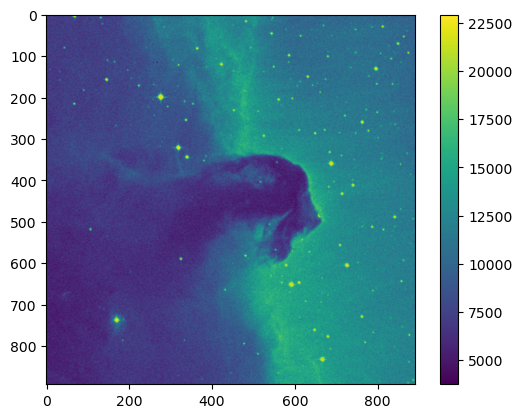

In [110]:
%matplotlib inline

plt.imshow(image_data, cmap='viridis')
plt.colorbar()
plt.show()

# To see more color maps
# http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps
# See also https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/

This is nice, but you have to be careful as the x-y axes appearing here are a bit misleading. 

First you can notice that the y axis is reversed. If your astronomical image follows typical conventions, it will be North up and East left, but here *up is down*. Let's plot it again after telling `plt.imshow` you want the origin of the y axis at the bottom:

In [ ]:
plt.imshow(image_data, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

Another thing to remember is that an array is indexed as `[row index, column index]`, hence the first index corresponds to `y` and the second to `x`, while... plotting inputs should be provided as (x, y)!

A bright star is approximately located at `(170, 738)` on the top left of the image. Imagine you would like to get its flux value. For that be mindful that you need to look at `image_data[738, 170]`... otherwise you may end up measuring the flux of another star:

In [ ]:
plt.imshow(image_data, cmap='viridis', origin='lower', vmin=8000, vmax=18000)
plt.plot(170, 738, 'd', color='green') # The star of interest ! 
plt.plot(738, 170, 'x', color='red')  # Wrong location in the image 
plt.colorbar()
plt.show()

In summary, to access the values in the array, you have to swap between `x` and `y` positions compared to the x,y you see with `plt.imshow()`, or w.r.t. the position you would measure with another viewer (e.g. [DS9](https://sites.google.com/cfa.harvard.edu/saoimageds9/download), [QFitsView](https://www.mpe.mpg.de/~ott/QFitsView/)). Note also that the pixel positions given by these viewers start at (1,1) (so you have to subtract 1). 

Now let's come back to manipulating our image. 
You can e.g. get some basic statistics about your image.

In [ ]:
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Standard deviation:', np.std(image_data))

You can also plot histograms of some regions of the image. 
To make a histogram with `matplotlib.pyplot.hist()`, you need to cast the data from a 2-D to array to something one dimensional.    

For that purpose, you can use either the `flat` attribute of your array which is a so-called *flat iterator* (it enables to iterate over your array in a single dimension) or the `flatten()` method on your array, which returns a flattened (1D) copy of your array.



In [ ]:
histogram = plt.hist(image_data.flat, 1000)
plt.show()

Want to use a logarithmic color scale? To do so you need to load the `LogNorm` object from `matplotlib`.

In [ ]:
from matplotlib.colors import LogNorm

plt.imshow(image_data, cmap='viridis', origin='lower', norm=LogNorm(vmin=4000, vmax=22000))
plt.colorbar()
plt.show()

Note that in the previous cell we set `vmin` and `vmax` as the cuts of the stretch based on the histogram values.
When not using a log scale, `vmin` and `vmax` can be passed directly as `plt.imshow()` arguments (instead of LogNorm arguments).

#### 3.1.3 Writing image data to a FITS file

Whether it is an astronomical image that you have modified, a model image, or any numpy ndarray representing an image (or cube of images), they can easily be written as FITS files. This can be done by:
- defining a primary HDU in which you provide your data array,
- using the `writeto()` method providing the name of your file.

For example, let's crop our Horsehead nebula image to just include the head of the horse, and save the cropped image into a new FITS file:

In [116]:
crop_image = image_data[300:700, 300:700]

In [117]:
outfile = 'outputs/HorseHead_crop.fits'

hdu = fits.PrimaryHDU(crop_image)
hdu.writeto(outfile, overwrite=True)

**Note:** you will get an error message if the file you are trying to write already exists. To avoid this and allow for overwriting, you should set the option `overwrite=True`.

Optionally (but always recommended), you can provide a header. By default a few cards are always written in the header even if no header is passed (mostly the cards associated to the image dimensions).

You will see in the next section how to edit a header, and write it together with an image to a new FITS file.

### 3.2. Editing FITS images and headers

One of the most common tasks when processing astronomical data is to perform some operation on some image(s) and write it/them to a new FITS file, appending a modified header.

Let's now see how to do that.


#### 3.2.1 Access and edit the header

There is basically three equivalent ways to access the header: 

1. Through the hdulist (element 0 if you want the header associated with the first HDU): 
``` python
header = hdulist[0].header
```


2. Using the convenience function getdata, specifying the option `header=True`, and also `ext=0`. Hence: 
``` python
data, header = fits.getdata('input_file.fits', header=True, ext=0)
```

3. Using a convenience function `fits.getheader()`, specifying the HDU extension:
``` python
header = fits.getheader('input_file.fits', 0)
```

Those functions/attribute return a Header instance, another Astropy object. To get the value associated with a header keyword, you do as you do to access elements of a python dictionary:
`header['OBJECT']`. 

**Example 1:** Let's load the header of the first image of an observation of Messier object M13, add one additional piece of information in the header, and finally save the new FITS file:

In [ ]:
data, header = fits.getdata('data/M13_blue_0001.fits', header=True, ext=0)
header

In [ ]:
plt.imshow(data)
plt.show()

Although keyword names are always in upper case inside the FITS file, specifying a keyword name with Astropy is case-insensitive, for the user’s convenience.

This header is filled only with default values, you can add some cards. For example, one could add a crucial piece of information: the correct object name.

You could do:
'''
header['OBJECT'] = 'M31'
'''
But as that header keyword does not exist yet, you do not have any description of that keyword. It is thus preferrable to provide a tuple instead, where the second element provides a brief description of the keyword: 

In [ ]:
header['OBJECT'] = ('M31', 'Object name')
header

Finally, write out a new FITS file. Again, the convenience  function for this is the most useful command to remember:

In [121]:
fits.writeto('outputs/M13_blue_0001_edited.fits', data, header, overwrite=True)

The option `overwrite = True` is needed to overwrite the file if already existing. 

**Example 2:** You learn a posteriori that the reduction pipeline used to calibrate your image erroneously underestimate all pixel intensities by 10%, and want to correct for that.

Instead of using getdata (as shown in Example 1), one can work exclusively with hdulist (and modified `data` and/or `header` instances). In that case you can also save your new FITS file (with all its layers !) using: 
`hdulist.writeto('newfile.fits')` :

In [122]:
image_file = 'data/M13_blue_0001.fits'

hdu_list = fits.open(image_file)
hdu_list[0].data = hdu_list[0].data*1.1
hdu_list.writeto('outputs/M13_blue_0001_scaled.fits', overwrite=True)
hdu_list.close()

#### 3.2.2 Creating a brand-new fits image file

Imagine you have a numpy array containing a model image or some data that do not come from a FITS file, which you want to save as a FITS file. For simplicity here, we'll consider a random array:

In [123]:
myarray = np.random.random((20, 10))
hdu = fits.PrimaryHDU(myarray)

Let's then create a HDUList to contain the newly created primary HDU (even if it only contains a single HDU), and write to a new file:

In [ ]:
plt.imshow(myarray)
plt.show()

In fact, Astropy even provides a shortcut for the last two lines in case of a single HDU (i.e. no extensions) to accomplish the same behavior: `hdu.writeto('new.fits')`

In [125]:
hdulist = fits.HDUList([hdu])
hdulist.writeto('outputs/noise.fits', overwrite=True)

In [126]:
hdu.writeto('outputs/noise.fits', overwrite=True)

#### 3.2.3 `HISTORY` and `COMMENT` cards:

Some of the fits CARDS have different properties than the others. Normal cards are unique and should be no larger than 80 characters. 
For the `HISTORY` and `COMMENT` cards, each new entry will be appended after the previous one (i.e. those keywords can be seen as lists on multiple elements, while other keywords only have one element). 

**Example 1:** You want to provide the information in the header that the night was not photometric during the observation.

In [ ]:
header['COMMENT'] = 'Night was not photometric'
header

**Example 2:** You want to mention in some HISTORY cards when you last edited the file (this is a relatively common practice, also for reduction pipelines).

This can be done straightforwardly with the `datetime` package (useful e.g. in an automated pipeline). Alternatively, for this example you can define manually a string containing the date.

In [ ]:
from datetime import datetime
now = datetime.now()

header['HISTORY'] = 'I updated this file on '+now.strftime('%Y-%m-%d %H:%M:%S')
header

Let's add a couple more comments:

In [ ]:
header['COMMENT'] = 'First of 10 images'
header

The COMMENT and HISTORY cards behave differently from other keywords. New instances of the keyword get *added* instead of *replacing* the existing ones.

As for other header keywords, values can be accessed as in a dictionary:

In [ ]:
header['COMMENT']

To replace a comment, one needs to provide its index. For example, to correct a mistake in a comment:

In [ ]:
header['COMMENT'][1] = 'First of 5 images'
header

To delete a header keyword, one needs to use the del function, either with the keyword name or row index:

In [ ]:
del header['SWMODIFY']
header

If you want to delete a specific comment row, but not the others you'd have to do it by row index:

In [ ]:
del header[-2]
header

---

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 3.1:** 
One of the most common operation with sets of astronomical images is **image stacking**. This is done to increase the signal-to-noise of objects of interest.
The 'data' subfolder contains 5 FITS images of Messier object M13 obtained with a ~10'' telescope.
1. Open the images
2. Sum them
3. Plot a histogram of pixel intensities.
4. Use plt.imshow to show the resulting stacked image, after wisely choosing the cuts of your stretch based on the histogram.
5. Write a new FITS file in the 'outputs' subfolder containing the stacked image, and an edited version of the original header with an additional comment.

</div>

In [ ]:
image_list = ['data/_blue.fits' for n in range()] # Write a list comprehension that creates the list of images to stack, locaed in subdir data 
image_concat = [ for image in image_list] # Create a list with images opened 

Now let's stack the images by summing the concatenated list (note: taking the median can also be a good option to get rid of bad pixels due to cosmic rays).

In [ ]:
stacked_image = np. # Sum the images 
stacked_image.shape

(1040, 1392)

In [ ]:
plt.imshow(stacked_image)
plt.show()

Let's then visualize the histogram to decide on the best stretch for vizualisation.

In [ ]:
nbins = 
image_hist = plt.hist(stacked_image.flat, nbins)
plt.show()

If not setting cuts based on the histogram, we'll be dominated by a few outlier pixels which will affect the visibility of the image:

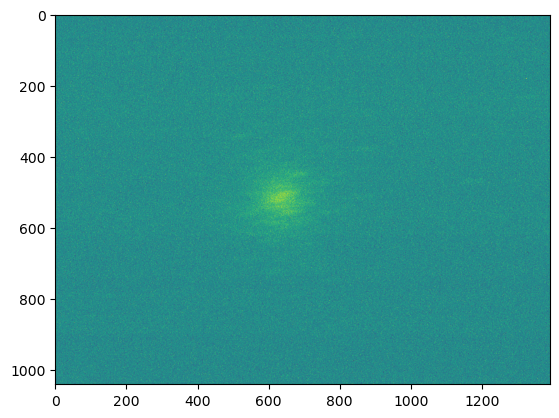

In [ ]:
plt.imshow(stacked_image, vmin=, vmax=)
plt.show()

You can also set the stretch more automatically using `np.percentile`.

In [ ]:
np.percentile(stacked_image, ), np.percentile(stacked_image, )

In [ ]:
plt.imshow(stacked_image, vmin=np.percentile(stacked_image, ), vmax=np.percentile(stacked_image, ))
plt.show()

In [ ]:
# Intermezo 
# Look at some of the individual images ; do they look similar
plt.imshow(image_concat[], vmin=, vmax=)
plt.show()

**The resulting (combined) image is blurry. What could be the reason?**

Now let's write the stacked image, including a new header.
Instead of defining a header from scratch, it makes a lot of sense to just re-use one of the original headers of the FITS files, and add/adapt a COMMENT line and a HISTORY line:

In [ ]:
orifile = 'data/.fits'
orihead = (orifile) # read the header that you want to copy and modify 

Let's check the original header:

In [ ]:
orihead

Let's now make a copy and edit the header copy:

In [ ]:
from datetime import datetime
now = datetime.now()
new_head = orihead.copy()
new_head[] = 'Combination of 5 images'
new_head['HISTORY'] = 'Last edited on '+now.strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
new_head

Finally let's save our image with the new header:

In [ ]:
stacked_image.dtype

In [ ]:
outfile = 'outputs/M13_blue_stacked.fits'
hdu = fits.PrimaryHDU(stacked_image.astype('uint16'), header=new_head) # Conversion to uint16 to keep correct units
hdu.writeto(outfile, overwrite=True)   # Effectively writing the fits 

**Note:** The conversion to 'int16' is optional. However the data type of the numpy array is automatically used to create a header card (BZERO), which is what FITS viewers (DS9 or QFitsView) use to display the 'correct' physical values in your images (BZERO+BSCALE*array_values). Here summing the 5 original 'int16' images led to our stacked image becoming of type 'int64', which means its direct writing as is would lead to an incorrect card in the header (BZERO = 1e8 instead of BZERO = 32768). We avoid this issue by converting the stacked image to 'int16'.

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 3.2:** Another common task when dealing with astronomical images is to **subtract the background**. Consider the Horsehead image loaded in Sec. 3.1.1.

1. Select several regions which are apparently sky regions. 
2. For simplicity, let's assume that the background is constant over the whole image and subtract the background level from the image. 
3. Plot the histogram of pixel values for the background subtracted image and display this background subtracted image with adequate cuts.
4. Write the background-subtracted image into a new FITS file, including the original header, and new comment/history cards.

</div>

In [ ]:
plt.imshow(image_data, origin='lower')
plt.colorbar()
plt.show()

In [ ]:
#1.
bkg_area = image_data[]  # Select region for bgd estimate  
bkg_proxy = np.percentile(bkg_area, 5)   # Our proxy to the bgd; This is not really standard
bkg_proxy

In [ ]:
#2.
bkg_sub_img = 

In [ ]:
#3.
image_hist = plt.hist(bkg_sub_img.flat, 1000)

In [ ]:
plt.imshow(bkg_sub_img)
plt.colorbar()
plt.show()

In [ ]:
#4. 
horse_head = fits.getheader('data/HorseHead.fits')
horse_head

In [ ]:
# Modify the header 
horse_head[] =  # Add a COMMENT explaining what you did   
horse_head['HISTORY'] = 'Last edited on '+now.strftime('%Y-%m-%d %H:%M:%S')  # Add a time tag 
horse_head

In [ ]:
# Write the output ino a file
hdu = 
hdu.writeto("outputs/Horsehead_bkg_sub.fits", overwrite=True)

#### 3.3. FITS Tables

A FITS table will *always* be in an extension HDU, never in a primary HDU.

There are two kinds of tables in the FITS standard:
* **Binary tables**: these are more economical in storage and faster in data access and manipulation.
* **ASCII tables**: these store the data in a “human readable” form and therefore take up more storage space as well as more processing time since the ASCII text needs to be parsed into numerical values.

We can proceed as for images to see or load the content of a FITS file containing FITS tables.  

To illustrate how to extract information from FITS tables, let's consider a big FITS table corresponding to a Chandra X-ray observation of the Galactic Center, in "data/chandra_events.fits".  The file contains a list of events with x and y coordinates, energy, and various other pieces of information. Since the file is big, we will open it with `memmap=True` to prevent RAM storage issues.

In [ ]:
event_filename = 'data/chandra_events.fits'
hdu_list = fits.open(event_filename, memmap=True)
hdu_list.info()

We are interested in reading `EVENTS`, which contains information about each X-ray photon that hit the detector. 

We see in the `Dimensions` columns of the output of `info` that the different HDU (from the second one) contains a certain number of "rows" (`R`) and "columns" (`C`). You can print the column name simply using the attribute `columns` : 

In [ ]:
hdu_list[1].columns

To access the table data (content of the columns) you can follow the same procedure as for images, i.e. extract the `data` part of the HDU:

In [174]:
event_data = hdu_list[1].data

FITS tables are **record arrays**:

In [ ]:
type(event_data)

A record array is an array which contains records (i.e., rows) of heterogeneous data types. Record arrays are available through the `records` module in the NumPy library. These are not necessarily convenient to visualize though:

In [ ]:
event_data

Fortunately, they can be straightforwardly converted into Astropy Tables (more details in next section).

In [ ]:
from astropy.table import Table
evt_data_tab = Table(event_data)
evt_data_tab

In [182]:
# You can also open directly as an Astropy Table:
event_data = Table.read(event_filename, format='fits', hdu=1)

Nonetheless, extracting data and useful information from the FITS table doesn't always require conversion to Astropy Table. Let's illustrate a couple of use cases where data can be directly extracted through the columns of the FITS table (these columns can be inferred from the output of `hdu_list[1].columns`).

**Example 1:** Plot the distribution of X-ray photon energies that hit the detector.

Let's consider the relevant column of the table:

In [ ]:
energies = event_data['energy']
len(energies)

In [ ]:
len(event_data)

And plot a histogram of the events energy:

In [ ]:
energy_hist = plt.hist(energies, 1000)
plt.xlabel('Energy (eV)')
plt.ylabel('Counts')
plt.show()

**Example 2:** Make a 2D histogram based on the tabular data, which represents the distribution of photon hits on the detector.

For this, let's bin the x and y coordinates of the events into a 2D histogram.

This particular observation spans 7 CCD chips.  First, we determine the events that only fell on the main (ACIS-I) chips, which have number ids 0, 1, 2, and 3.

In [ ]:
event_data['ccd_id']

For this, we can produce a boolean array which identifies which hits were recorded on chips 0, 1, 2 or 3:

In [ ]:
ii = np.isin(event_data['ccd_id'], [0, 1, 2, 3])
ii

In [ ]:
np.sum(ii)

For comparison, this was the total length of the column (and of the Table):

In [ ]:
len(event_data)

Now let's check the result obtained with 2D histogram utility of pyplot:

In [ ]:
nbins = (100, 100)
img_zero_mpl = plt.hist2d(event_data['x'][ii], event_data['y'][ii], nbins,
                          cmap='inferno')
cbar = plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show(img_zero_mpl)

The counts seem highly concentrated in the same area of the sky. Let's rather use a Log stretch:

In [ ]:
img_zero_mpl = plt.hist2d(event_data['x'][ii], event_data['y'][ii], nbins,
                          cmap='inferno', norm=LogNorm())
cbar = plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Nice - you have located the roaring signature of the hungry **supermassive black hole** at the center of our Galaxy.

When you're done using a FITS file, it's always a good idea to close it.  That way you can be sure it won't continue using up excess memory or file handles on your computer.  (This happens automatically when you close Python, but you never know how long from now that might be...)

In [192]:
hdu_list.close()

[Go back to top](#Table-of-contents)

## 4. Astropy Tables

Now let's see the advantages of converting tabular data in Astropy [Tables](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table):

Compared to e.g. numpy structured arrays, Astropy `Table` objects:
- are very convenient to handle heterogeneous tabular data;
- have the ability to easily modify the structure of the table by adding or removing columns, or adding new rows of data;
- can handle missing data.

### 4.1. Reading a Table

Let's first see how we can create an Astropy Table object from tabular data. 

`astropy` enables you to read tabular data in a large variety of formats, including `fits tables`. 
If you read a fits table from a fits file, you may have to indicate which hdu you are interested in as a supplementary argument. If you do not, astropy will try to open the first valid hdu it identifies. 


In [196]:
from astropy.table import Table
from astropy.io.fits import getdata

# You can also open a fits and convert into a table. This method requires two steps and may not conserve the units into the table
# event_data = getdata("data/chandra_events.fits")      # load FITS data
# evt_data_tab = Table(event_data)  # convert to Astropy Table
# evt_data_tab

evt_data_tab = Table.read("data/chandra_events.fits", format='fits', hdu=1)  # direct read as Astropy Table

In [ ]:
evt_data_tab_direct = Table.read("data/chandra_events.fits", format='fits', hdu=1)  # direct read as Astropy Table
evt_data_tab_direct[0:5]

Astropy provides a unified interface for reading and writing data in different formats (see help of `astropy.Table` for more details). For non binary format (like fits), the data file often contains information about the columns over the first line/lines of the file. In ascii-like tables (i.e. table that you can read with a standard text editor; `csv` and `tsv` an ascii format) is common to use `#` to indicate that a row is a comment. 

For many common cases astropy will simplify the process of file I/O and reduce the need to master the separate details of all the I/O packages within Astropy. 

**Example 1:** Let's load the X-match result file we wrote earlier ('outputs/Xmatch_result.csv'):

In [ ]:
t = Table.read('outputs/Xmatch_result.csv')#, format='ascii')
t

**Example 2:** The file `'data/Young-Objects-Compilation.csv'` contains a compilation of young objects, their coordinates and some properties, including measured magnitudes. The file has nonetheless been a bit corrupted (which is fine as Astropy Tables can handle missing data), and contains an uncommon number of header rows.

</div>

Let's first try to load the Table as before, with the default parameters of the `read()` function:

In [ ]:
tab = Table.read('data/Young-Objects-Compilation.csv')
tab[0:10]

In [ ]:
tab.columns

What happened? It looks like the function failed to read the column names. Also notice that the first row of data are strings:

A few things are causing problems here. First, there are two header 
lines in the file and the header lines are not denoted by comment 
characters. The first line is actually some meta data that we don't
care about, so we want to skip it. We can get around this problem by 
specifying the `header_start` keyword to the `Table.read()` function. 
This keyword argument specifies the index of the row in the text file 
to read the column names from:

In [ ]:
tab = Table.read('data/Young-Objects-Compilation.csv', header_start=1)
tab[0:10]

In [ ]:
# You can access the column names as a list:
tab.colnames

Sometimes, the header is effectively a bit more ocmplex and the data do not start straight away. 
the keyword argument `data_start` enables you to indicate astropy at which row the data start. 
For instance, for our data we could specify `data_start=2` to tell the reader that the data in
this file actually start on the 3rd (index=2) row :
```python
tab = Table.read('data/Young-Objects-Compilation.csv', header_start=1, data_start=2)
```

(This was needed for that file with older versions of astropy which assumed as a default that data start at the second row (index=1)). 

**Parenthesis on missing data.** As can be seen above, Astropy Tables can handle missing data (see e.g. the `RA` or `J_unc` columns). The missing data are denoted by "--" when printed:

In [ ]:
print(tab['RA'])

Such Column is called a __Masked Column__ because some missing values are 
masked out upon display. 

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side note:** Masked columns are essentially **Column** objects containing a **numpy masked array** (`numpy.ma` class). More info about the latter [here](https://numpy.org/doc/stable/reference/maskedarray.generic.html). Useful properties and attributes:
- Aggregation functions (e.g. np.sum, np.mean) simply ignore the masked entries -- while np.sum() on an array with NaN values will yield NaN.
- The `data` or `value` (equivalent) attributes return the numpy masked array held in the masked column.
- A very useful *attribute* of such objects is `mask`, which is a numpy array of booleans corresponding to the entries that are masked (a property inherited from the numpy masked array).

</div>

In [ ]:
print(type(tab['RA']))
print(type(tab['RA'].value))
print(type(tab['RA'].data))

One can easily identify the entries with missing values with the `mask` attribute:

In [ ]:
tab['RA'].mask

To only keep non-masked entries, one can simply take the "not" operator (~). For example, to only consider the J-band magnitude uncertainties that are defined:

In [ ]:
defined_Junc = tab['J_unc'][~tab['J_unc'].mask]
defined_Junc

As said before, the aggregation operations simply ignore missing values:

In [ ]:
print(np.mean(defined_Junc), np.mean(tab['J_unc']))

If we want to use the numeric data in a masked column, it can in some cases be useful to fill all of the missing
values with `NaN`'s. This can be done with the `.filled()` method:

In [ ]:
tab['RA'].filled(np.nan)

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 4.1:** Use matplotlib to make a J-K color-magnitude diagram (i.e. plot J-K vs. J) for the objects in the `'data/Young-Objects-Compilation.csv'` table.

</div>

Reminder to properly load the table with old version of astropy:
- our data file has an extra line above the column names, so we
use the `header_start` keyword to tell it to start from line 1 instead
of line 0 (remember Python is 0-indexed!)
- specify that the data start on line 2 using the `data_start`.

In [ ]:
tab = # Command to load our csv table

In [ ]:
# visualuse first entries 

When the data are properly loaded, plotting a color-magnitude diagram is very easy.

It is a matter of making a scatter plot of the J-K color on the x-axis
against the J magnitude on the y-axis:

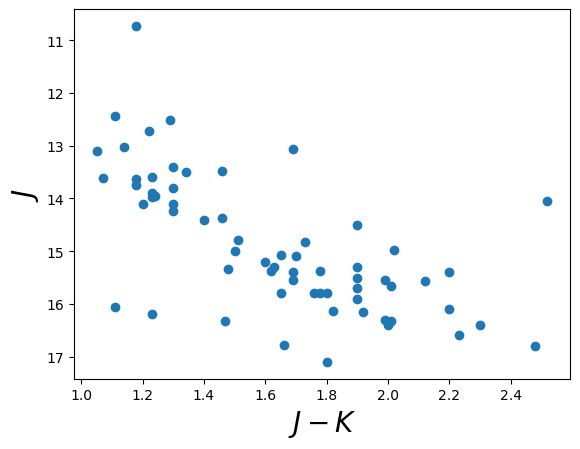

In [ ]:
plt.scatter() # Command to plot J-K vs J
plt.gca().invert_yaxis() # To get lower values of the mag up / brightest objects at the top
plt.xlabel("$J-K$", fontsize=20)
plt.ylabel("$J$", fontsize=20)
plt.show()

### 4.2. Constructing, modifying and writing a Table

Can be done straightforwardly with a list of lists or numpy arrays passed as columns.
The data format can be very heterogeneous, including or not Astropy Quantities.
**Example:**

In [228]:
from astropy.table import QTable
import astropy.units as u

a = np.array([1, 4, 5], dtype=np.int32)
b = [2.0, 5.0, 8.5]
c = ['x', 'y', 'z']
d = [10, 20, 30] * u.m / u.s

t = QTable([a, b, c, d], 
           names=('a', 'b', 'c', 'd'),
           meta={'name': 'the first table'})

In [ ]:
t

Modifying a Table then works in a similar way as numpy ndarrays - it can be done in place.

**Examples:**

In [230]:
t['a'][:] = [1, -2, 3]  # replace all values of column 'a'
t['a'][2] = 30          # replace a specific element
t[1] = (8, 9.0, 'v', 11*u.m/u.s) # to replace a row
t[1]['b'] = -9          # alt. way to replace element
t[0:3]['c'] = 'x'       # replace rows 0, 1 , 2 of column 'c'

In [ ]:
t

Writing a table is as simple as:

In [232]:
t.write("outputs/example_table.txt", format='ascii', overwrite=True)

In [233]:
t.write("outputs/example_table.csv", format='csv', overwrite=True)

In [ ]:
t.write?

A lot of formats are supported. As usual it is a matter of checking the docstrings to know what can be done (`t.write?`). 

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 4.2:** Load again the file `'data/Young-Objects-Compilation.csv'`, and correct the data type for columns 'W3_unc' and 'W4_unc' (they should be 'float'), and finally write the corrected table into a new csv file `'outputs/Young-Objects-Compilation_corr.csv'`.

Tip 1: make new MaskedColumn objects where you mask the 'null' elements. (`from astropy.table import MaskedColumn`)

Tip 2: use list comprehension to correct for the type of each element of the MaskedColumns, and use the new lists to define the new MaskedColumns.

</div>

First load and check out the table:

In [ ]:
tab = Table.read('data/Young-Objects-Compilation.csv', header_start=1, data_start=2)
tab

Some values are marked as 'null' instead of being actual missing values in the 'W3_unc' and 'W4_unc' columns. Let's make them MaskedColumn objects:

In [ ]:
from astropy.table import MaskedColumn
# Create a masked column where 'null' entries are masked
tab['W3_unc'] = MaskedColumn(tab[], mask=tab[]=='null')
tab['W4_unc'] = MaskedColumn(tab[], mask=tab[]=='null')

Use list comprehension for conversion of all element's type:

In [ ]:
W3_unc = [float([i]) for i in range(len())] 
W4_unc = 

A warning is raised, but by default masked elements are converted to NaN values.

Let's now redefine the Columns 'W3_unc' and 'W4_unc' as Masked Column objects, with data type set to 'float':

In [ ]:
tab['W3_unc'] = MaskedColumn(W3_unc, dtype=, mask=tab['W3_unc'].mask)
tab['W4_unc'] = MaskedColumn(W4_unc, dtype=, mask=tab['W4_unc'].mask)

Let's check the corrected table:

In [ ]:
tab

All good - the relevant columns have been corrected. Let's now write the new table:

In [ ]:
tab.write( )

### 4.3. Table operations

Let's review convenient ways to generate new Tables from one or multiple input Tables, enabled by methods of the Astropy `Table` class.

#### 4.3.1. Table Groups

We can sort the table by groups, based on one of the values in one of their columns.

Let's illustrate this with the following example table:

In [292]:
from astropy.table import Table
ob1 = Table.read("""name    obs_date    mag_b  mag_v
                    M31     2012-01-02  17.0   17.5
                    M31     2012-01-02  17.1   17.4
                    M101    2012-01-02  15.1   13.5
                    M82     2012-02-14  16.2   14.5
                    M31     2012-02-14  16.9   17.3
                    M82     2012-02-14  15.2   15.5
                    M101    2012-02-14  15.0   13.6
                    M82     2012-03-26  15.7   16.5
                    M101    2012-03-26  15.1   13.5
                    M101    2012-03-26  14.8   14.3
                    """, format='ascii')

In [293]:
# Make sure magnitudes are printed with one digit after the decimal point
ob1['mag_b'].info.format = '{:.1f}'
ob1['mag_v'].info.format = '{:.1f}'

Let's group by object name:

In [ ]:
ob1_by_name = ob1.group_by('name')
#print(ob1_by_name)
ob1_by_name

In [ ]:
ob1_by_name.groups.keys

In [ ]:
# We can get the indices of the first and last (but plus one) item in the group as follows 
group_indices = ob1_by_name.groups.indices
print(group_indices)
ob1_by_name[group_indices[0]:group_indices[1]]  # group for M101 (first key)

Different operations can be applied on the data from different groups, for example through the definition of a mask:

In [ ]:
mask = ob1_by_name.groups.keys['name'] == 'M101'
print(ob1_by_name.groups[mask])

New tables can be defined as corresponding to specific groups only:

In [ ]:
groupA = ob1_by_name.groups[0:2]
print(groupA)

#### 4.3.2. Aggregation

Properties can be inferred by **aggregation** of specific groups. For example, let's calculate the mean magnitudes for each group:

In [ ]:
ob1_mean = ob1_by_name.groups.aggregate(np.mean)
print(ob1_mean)

#### 4.3.3. Filtering

Tables can be filtered/sliced with a boolean condition, in a similar fashion as numpy arrays.

In addition, Table groups can be filtered by means of the `filter()` method (for more complex filtering operations). This is done by supplying a function which is called to filter each group. The function which is passed to this method must accept two arguments: a Table object and a tuple of column names *used for grouping*. 

**Example:** Let's only consider positive values in given columns of a manually-defined Table.

In [300]:
def all_positive(table, key_colnames):
    ''''
    Function for filtering a table to check if all values in columns that 
    are not the grouping columns are positive
    '''
    colnames = [name for name in table.colnames if name not in key_colnames]
    for colname in colnames:
        if np.any(table[colname] <= 0):
            return False
    return True

In [301]:
t = Table.read(""" a   b    c
                  -2  7.0   2
                  -2  5.0   1
                   1  3.0  -5
                   1 -2.0  -6
                   1  1.0   7
                   0  4.0   4
                   3  3.0   5
                   3 -2.0   6
                   3  1.0   7""", format='ascii')

Let's first make groups based on the values in column 'a':

In [ ]:
tg = t.group_by('a')
print(tg)

Now let's filter groups to only consider the ones where all values are positive (in the other columns):

In [ ]:
t_positive = tg.groups.filter(all_positive)
for group in t_positive.groups:
    print(group)
    print('')

In [ ]:
tg.groups.filter?

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 4.2:** Consider your corrected table with Young object magnitudes (`'outputs/Young-Objects-Compilation_corr.csv'`), and filter out the rows with missing values for 'W3_unc'.

</div>

First load and check out the table. Note with the corrected table, default parameters for the `Read` function should work.

In [ ]:
tab = Table.read('outputs/Young-Objects-Compilation_corr.csv')
tab

**Method 1**: Use the mask property - in a similar fashion as numpy arrays.

In [ ]:
tab_filt =   # use .mask to filter rows where W3_unc is not masked
tab_filt[0:5]

Name,Designation,RA,Dec,Jmag,J_unc,Hmag,H_unc,Kmag,K_unc,W1,W1_unc,W2,W2_unc,W3,W3_unc,W4,W4_unc,Spectral Type,Spectra (FITS),Opt Spec Refs,NIR Spec Refs,pm_ra (mas),pm_ra_unc,pm_dec (mas),pm_dec_unc,pi (mas),pi_unc,radial velocity (km/s),rv_unc,Astrometry Refs,Discovery Refs,Group/Age,Note
str24,str25,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,int64,str26,str23,float64,float64,float64,float64,float64,float64,int64,int64,str19,str23,int64,str38
--,00 04 02.84 -64 10 35.6,1.01201,-64.18,15.79,0.07,14.83,0.07,14.01,0.05,13.37,0.03,12.94,0.03,12.18,0.24,9.16,--,L1γ,--,Kirkpatrick et al. 2010,--,--,--,--,--,--,--,--,--,--,Kirkpatrick et al. 2010,--,--
--,00 32 55.84 -44 05 05.8,8.23267,-44.08,14.78,0.04,13.86,0.03,13.27,0.04,12.82,0.03,12.49,0.03,11.73,0.19,9.29,--,L0γ,--,Cruz et al. 2009,--,0.1178,0.0043,-0.0916,0.0043,38.4,4.8,--,--,Faherty et al. 2012,Reid et al. 2008,--,--
--,00 37 43.06 -58 46 22.9,9.42942,-58.77,15.37,0.05,14.26,0.05,13.59,0.05,13.13,0.03,12.74,0.03,12.56,0.38,9.32,--,L0γ,--,Cruz et al. 2009,--,0.049,0.01,-0.051,0.02,--,--,--,--,Faherty et al. 2009,Reid et al. 2008,--,--
--,00 45 21.43 +16 34 44.6,11.33929,16.58,13.06,0.02,12.06,0.04,11.37,0.02,10.77,0.02,10.39,0.02,9.74,0.04,8.42,0.26,L2β,--,Cruz et al. 2009,Wilson et al. 2003,0.385,0.017,-0.026,0.012,--,--,--,--,Faherty et al. 2009,Wilson et al. 2003,--,--
--,Empire,--,--,13.8,--,13.1,--,12.5,--,12.07,0.03,11.64,0.02,11.14,0.18,9.02,--,M9β,--,Reid et al. 2008,Wilson et al. 2003,0.098,0.022,-0.051,0.01,--,--,--,--,Faherty et al. 2009,Wilson et al. 2003,--,--


**Method 2**: Sort by groups and define a filtering function.

Let's group by designation:

In [ ]:
tg_des =   # Sort by group 
tg_des[0:6]

Name,Designation,RA,Dec,Jmag,J_unc,Hmag,H_unc,Kmag,K_unc,W1,W1_unc,W2,W2_unc,W3,W3_unc,W4,W4_unc,Spectral Type,Spectra (FITS),Opt Spec Refs,NIR Spec Refs,pm_ra (mas),pm_ra_unc,pm_dec (mas),pm_dec_unc,pi (mas),pi_unc,radial velocity (km/s),rv_unc,Astrometry Refs,Discovery Refs,Group/Age,Note
str24,str25,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,int64,str26,str23,float64,float64,float64,float64,float64,float64,int64,int64,str19,str23,int64,str38
--,00 04 02.84 -64 10 35.6,1.01201,-64.18,15.79,0.07,14.83,0.07,14.01,0.05,13.37,0.03,12.94,0.03,12.18,0.24,9.16,--,L1γ,--,Kirkpatrick et al. 2010,--,--,--,--,--,--,--,--,--,--,Kirkpatrick et al. 2010,--,--
PC 0025+04,00 27 41.97 +05 03 41.7,6.92489,5.06,16.19,0.09,15.29,0.1,14.96,0.12,14.62,0.04,14.14,0.05,12.24,--,8.89,--,M9.5β,--,Mould et al. 1994,--,0.0105,0.0004,-0.0008,0.0003,--,--,--,--,Faherty et al. 2009,Schneider et al. 1991,--,--
--,00 32 55.84 -44 05 05.8,8.23267,-44.08,14.78,0.04,13.86,0.03,13.27,0.04,12.82,0.03,12.49,0.03,11.73,0.19,9.29,--,L0γ,--,Cruz et al. 2009,--,0.1178,0.0043,-0.0916,0.0043,38.4,4.8,--,--,Faherty et al. 2012,Reid et al. 2008,--,--
--,00 37 43.06 -58 46 22.9,9.42942,-58.77,15.37,0.05,14.26,0.05,13.59,0.05,13.13,0.03,12.74,0.03,12.56,0.38,9.32,--,L0γ,--,Cruz et al. 2009,--,0.049,0.01,-0.051,0.02,--,--,--,--,Faherty et al. 2009,Reid et al. 2008,--,--
--,00 45 21.43 +16 34 44.6,11.33929,16.58,13.06,0.02,12.06,0.04,11.37,0.02,10.77,0.02,10.39,0.02,9.74,0.04,8.42,0.26,L2β,--,Cruz et al. 2009,Wilson et al. 2003,0.385,0.017,-0.026,0.012,--,--,--,--,Faherty et al. 2009,Wilson et al. 2003,--,--
--,01 24 45.99 -57 45 37.9,21.19163,-57.76,16.31,0.11,15.06,0.09,14.32,0.09,13.77,0.03,13.34,0.03,12.45,0.31,8.91,--,L0γ,--,Cruz et al. 2009,--,-0.003,0.01,0.018,0.019,--,--,--,--,Faherty et al. 2009,Reid et al. 2008,--,--


Define the filtering function:

In [ ]:
def reject_missing_values(table, key_colnames):
 

Apply filtering function to groups:

In [310]:
tg_trim_w3 = tg_des.groups.filter(reject_missing_values)

Let's check:

In [311]:
tg_trim_w3

Name,Designation,RA,Dec,Jmag,J_unc,Hmag,H_unc,Kmag,K_unc,W1,W1_unc,W2,W2_unc,W3,W3_unc,W4,W4_unc,Spectral Type,Spectra (FITS),Opt Spec Refs,NIR Spec Refs,pm_ra (mas),pm_ra_unc,pm_dec (mas),pm_dec_unc,pi (mas),pi_unc,radial velocity (km/s),rv_unc,Astrometry Refs,Discovery Refs,Group/Age,Note
str24,str25,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,int64,str26,str23,float64,float64,float64,float64,float64,float64,int64,int64,str19,str23,int64,str38
--,00 04 02.84 -64 10 35.6,1.01201,-64.18,15.79,0.07,14.83,0.07,14.01,0.05,13.37,0.03,12.94,0.03,12.18,0.24,9.16,--,L1γ,--,Kirkpatrick et al. 2010,--,--,--,--,--,--,--,--,--,--,Kirkpatrick et al. 2010,--,--
--,00 32 55.84 -44 05 05.8,8.23267,-44.08,14.78,0.04,13.86,0.03,13.27,0.04,12.82,0.03,12.49,0.03,11.73,0.19,9.29,--,L0γ,--,Cruz et al. 2009,--,0.1178,0.0043,-0.0916,0.0043,38.4,4.8,--,--,Faherty et al. 2012,Reid et al. 2008,--,--
--,00 37 43.06 -58 46 22.9,9.42942,-58.77,15.37,0.05,14.26,0.05,13.59,0.05,13.13,0.03,12.74,0.03,12.56,0.38,9.32,--,L0γ,--,Cruz et al. 2009,--,0.049,0.01,-0.051,0.02,--,--,--,--,Faherty et al. 2009,Reid et al. 2008,--,--
--,00 45 21.43 +16 34 44.6,11.33929,16.58,13.06,0.02,12.06,0.04,11.37,0.02,10.77,0.02,10.39,0.02,9.74,0.04,8.42,0.26,L2β,--,Cruz et al. 2009,Wilson et al. 2003,0.385,0.017,-0.026,0.012,--,--,--,--,Faherty et al. 2009,Wilson et al. 2003,--,--
--,01 24 45.99 -57 45 37.9,21.19163,-57.76,16.31,0.11,15.06,0.09,14.32,0.09,13.77,0.03,13.34,0.03,12.45,0.31,8.91,--,L0γ,--,Cruz et al. 2009,--,-0.003,0.01,0.018,0.019,--,--,--,--,Faherty et al. 2009,Reid et al. 2008,--,--
--,01 41 58.23 -46 33 57.4,25.49263,-46.57,14.83,0.04,13.88,0.03,13.1,0.03,12.55,0.02,12.17,0.02,11.92,0.21,9.24,--,L0γ,--,Cruz et al. 2009,Kirkpatrick et al. 2006,0.104,0.017,-0.026,0.024,--,--,--,--,Faherty et al. 2009,Kirkpatrick06,--,--
SSSPM J0222-5412,02 21 54.94 -54 12 05.4,35.47892,-54.2,13.9,0.03,13.22,0.03,12.67,0.03,12.33,0.02,11.96,0.02,11.44,0.12,9.48,--,M9β,--,Reid et al. 2008,--,0.136,0.01,-0.01,0.017,--,--,--,--,Faherty et al. 2009,Lodieu05,--,--
--,02 23 54.64 -58 15 06.7,35.97767,-58.25,15.07,0.05,14.0,0.04,13.42,0.04,12.82,0.02,12.43,0.02,11.64,0.15,9.47,--,L0γ,--,Cruz et al. 2009,--,0.134,0.01,0.005,0.019,--,--,--,--,Faherty et al. 2009,Reid et al. 2008,--,--
--,02 25 19.47 -58 37 29.5,36.33113,-58.62,13.74,0.03,13.06,0.03,12.56,0.03,12.23,0.02,11.93,0.02,11.99,0.19,9.22,--,M9β,--,Reid et al. 2008,--,0.085,0.01,-0.03,0.018,--,--,--,--,Faherty et al. 2009,Reid et al. 2008,--,--


<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 4.3:** (Supplementary exercise)

Consider again your corrected table with Young object magnitudes (`'outputs/Young-Objects-Compilation_corr.csv'`). 

**1.** This time filter out all outliers defined as either:
- rows with missing values for 'W3_unc'
- rows with NY district name as 'Designation' instead of actual coordinates.

**2.** Then group by *spectral type* the table trimmed from all outliers, and write the new table (e.g.: `'outputs/Young-Objects-Compilation_SpT.csv'`).

Tip 1: Filtering can be done with multiple successive conditions, including conditions on the column name used for grouping.

Tip 2: A Try/Except statement where one tries to make a SkyCoord object with the 'Designation' may be a useful test to identify outliers...
</div>

In [ ]:
def reject_all_outliers(table, key_colnames):
    # remove missing W3 unc data
    if 
        return False
    # remove the NY district names ; return true if coordinate is properly defined
    try:
        c = coordinates.SkyCoord() 
    except:
        return False
    return True

Apply the new filtering function to groups:

In [314]:
tg_trim_all = tg_des.groups.filter(reject_all_outliers)

Let's check:

In [ ]:
tg_trim_all

Group the filtered table by Spectral Type:

In [ ]:
tg_spt = tg_trim_all 
tg_spt

In [ ]:
tg_spt.groups.keys

Write the new table:

In [318]:
tg_spt.write('outputs/Young-Objects-Compilation_SpT.csv', overwrite=True)

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side note:** Symbols $\beta$, $\gamma$ and $\delta$ in the **spectral type** denote the surface gravity of the object, with this sequence order corresponding to decreasing gravity. The youngest objects have the lowest gravity (not fully gravitationnally contracted yet). The $\alpha$ symbol typically denotes the gravity of field dwarfs (i.e. mature objects), and is therefore not in this table focused on young objects.
</div>

#### 4.3.4. Binning (FYI)

A common tool in analysis is to bin a table based on some reference value:

- Photometry of a binary star in several bands taken over a span of time which should be binned by orbital phase.
- Reducing the sampling density for a table by combining 100 rows at a time.
- Unevenly sampled historical data which should binned to four points per year.

All of these examples of binning a table can be accomplished using grouped operations. Example:

Let's first generate a fake light curve:

In [319]:
year = np.linspace(2000.0, 2010.0, 200)  # 200 observations over 10 years
period = 1.811
y0 = 2005.2
mag = 14.0 + 1.2 * np.sin(2 * np.pi * (year - y0) / period)
phase = ((year - y0) / period) % 1.0
dat = Table([year, phase, mag], names=['year', 'phase', 'mag'])
dat

year,phase,mag
float64,float64,float64
2000.0,0.12865819988953842,14.867805828715136
2000.0502512562814,0.15640599463354699,14.998416501448617
2000.1005025125628,0.1841537893775551,15.098756082307442
2000.1507537688442,0.21190158412156368,15.165782365291978
2000.2010050251256,0.2396493788655718,15.197463173683094
2000.251256281407,0.26739717360957993,15.192837973815648
2000.3015075376884,0.2951449683535885,15.15204699759679
2000.3517587939698,0.3228927630975966,15.076326990800439
2000.4020100502512,0.3506405578416052,14.967973716045861


Now let's make an array that will be used for binning the data by 0.25 year intervals:

In [320]:
year_bin = np.trunc(year / 0.25)  # np.trunc: truncate to nearest integer
year_bin

array([8000., 8000., 8000., 8000., 8000., 8001., 8001., 8001., 8001.,
       8001., 8002., 8002., 8002., 8002., 8002., 8003., 8003., 8003.,
       8003., 8003., 8004., 8004., 8004., 8004., 8004., 8005., 8005.,
       8005., 8005., 8005., 8006., 8006., 8006., 8006., 8006., 8007.,
       8007., 8007., 8007., 8007., 8008., 8008., 8008., 8008., 8008.,
       8009., 8009., 8009., 8009., 8009., 8010., 8010., 8010., 8010.,
       8010., 8011., 8011., 8011., 8011., 8011., 8012., 8012., 8012.,
       8012., 8012., 8013., 8013., 8013., 8013., 8013., 8014., 8014.,
       8014., 8014., 8014., 8015., 8015., 8015., 8015., 8015., 8016.,
       8016., 8016., 8016., 8016., 8017., 8017., 8017., 8017., 8017.,
       8018., 8018., 8018., 8018., 8018., 8019., 8019., 8019., 8019.,
       8019., 8020., 8020., 8020., 8020., 8020., 8021., 8021., 8021.,
       8021., 8021., 8022., 8022., 8022., 8022., 8022., 8023., 8023.,
       8023., 8023., 8023., 8024., 8024., 8024., 8024., 8024., 8025.,
       8025., 8025.,

To bin, we then group based on `year_bin` and aggregate using a mean:

In [321]:
dat_grouped = dat.group_by(year_bin)
dat_binned = dat_grouped.groups.aggregate(np.mean)
dat_binned

year,phase,mag
float64,float64,float64
2000.1005025125626,0.1841537893775552,15.065644790289252
2000.35175879397,0.32289276309759674,15.043891605119015
2000.603015075377,0.46163173681763825,14.27786227839583
2000.854271356784,0.6003707105378053,13.313722090895334
2001.105527638191,0.7391096842578468,12.83888584234561
2001.356783919598,0.8778486579778884,13.191903329685434
2001.6080402010052,0.4165876316979299,14.121079365321023
2001.8592964824122,0.1553266054179714,14.96392796772418
2002.1105527638192,0.2940655791380631,15.119513079325397


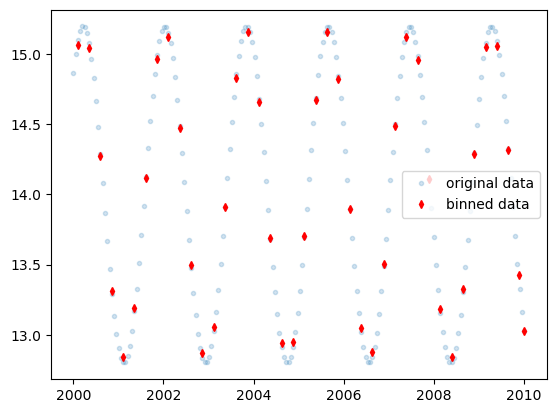

In [328]:
plt.plot(dat['year'], dat['mag'], '.', alpha=0.2, label='original data')
plt.plot(dat_binned['year'], dat_binned['mag'], 'd', ms=4, color='red', label='binned data')
plt.legend() 

#### 4.3.5. Concatenation (FYI)

Tables can be concatenated vertically, horizontally or in depth. Examples:

**Vertical stacking:**

In [329]:
from astropy.table import Table, vstack
obs1 = Table.read("""name    obs_date    mag_b  logLx
                     M31     2012-01-02  17.0   42.5
                     M82     2012-10-29  16.2   43.5
                     M101    2012-10-31  15.1   44.5""", format='ascii')

obs2 = Table.read("""name    obs_date    logLx
                     NGC3516 2011-11-11  42.1
                     M31     1999-01-05  43.1
                     M82     2012-10-30  45.0""", format='ascii')

In [330]:
print(vstack([obs1, obs2]))

  name   obs_date  mag_b logLx
------- ---------- ----- -----
    M31 2012-01-02  17.0  42.5
    M82 2012-10-29  16.2  43.5
   M101 2012-10-31  15.1  44.5
NGC3516 2011-11-11    --  42.1
    M31 1999-01-05    --  43.1
    M82 2012-10-30    --  45.0


Notice that the obs2 table is missing the mag_b column, so in the stacked output table those values are marked as missing. This is the default behavior and corresponds to join_type='outer'. There are two other allowed values for the join_type argument, 'inner' and 'exact':

In [331]:
print(vstack([obs1, obs2], join_type='inner'))

  name   obs_date  logLx
------- ---------- -----
    M31 2012-01-02  42.5
    M82 2012-10-29  43.5
   M101 2012-10-31  44.5
NGC3516 2011-11-11  42.1
    M31 1999-01-05  43.1
    M82 2012-10-30  45.0


In [332]:
print(vstack([obs1, obs2], join_type='exact'))  

TableMergeError: Inconsistent columns in input arrays (use 'inner' or 'outer' join_type to allow non-matching columns)

The 'exact' join type fails as the columns are not exactly the same.

**Horizontal stacking:**

In [333]:
from astropy.table import Table, hstack
t1 = Table.read("""a   b    c
                   1   foo  1.4
                   2   bar  2.1
                   3   baz  2.8""", format='ascii')
t2 = Table.read("""d     e
                   ham   eggs
                   spam  toast""", format='ascii')

In [334]:
print(hstack([t1, t2]))

 a   b   c   d     e  
--- --- --- ---- -----
  1 foo 1.4  ham  eggs
  2 bar 2.1 spam toast
  3 baz 2.8   --    --


#### 4.3.6. Differencing 

To compare two tables, you can use `report_diff_values()`. Example:

In [335]:
from astropy.utils.diff import report_diff_values
import sys
cat_1 = Table.read("""name    obs_date    mag_b  mag_v
                      M31     2012-01-02  17.0   16.0
                      M82     2012-10-29  16.2   15.2
                      M101    2012-10-31  15.1   15.5""", format='ascii')
cat_2 = Table.read("""name    obs_date    mag_b  mag_v
                      M31     2012-01-02  17.0   16.5
                      M82     2012-10-29  16.2   15.2
                      M101    2012-10-30  15.1   15.5
                      NEW     2018-05-08   nan    9.0""", format='ascii')

In [336]:
identical = report_diff_values(cat_1, cat_2, fileobj=sys.stdout)

     name  obs_date  mag_b mag_v
     ---- ---------- ----- -----
  a>  M31 2012-01-02  17.0  16.0
   ?                           ^
  b>  M31 2012-01-02  17.0  16.5
   ?                           ^
      M82 2012-10-29  16.2  15.2
  a> M101 2012-10-31  15.1  15.5
   ?               ^
  b> M101 2012-10-30  15.1  15.5
   ?               ^
  b>  NEW 2018-05-08   nan   9.0


In [337]:
identical

False

### 4.4. Comparison with Pandas DataFrames 

A large fraction of the data scientist community uses `Pandas`, a powerful data manipulation package for Python. Two main classes: Series and DataFrames. Series are numpy ndarray-like, while `DataFrames` are more like Tables.

Astronomers, and in particular the `Astropy` community, have developed more dedicated packages to deal with large astronomical datasets. The class of choice to deal with such large tabulated data is Astropy `Tables`.

Most common table format files:
- **HDF5** (Hierarchical Data Format version 5): the most popular in data science in general (gaining in popularity in astronomy). Designed to store and organize large amounts of data. Developed at the U.S. National Center for Supercomputing Applications.
- **CSV** (Comma Separated Values): popular in both astronomy and data science in general. Simple and in text format. Can be convenient for relatively small tables.
- **FITS** (Flexible Image Transport System): the most popular in astronomy. Used for transporting, analyzing, and archiving scientific data files. The format is endorsed by both NASA and the International Astronomical Union (IAU).

**Summary:**
- Astropy handles FITS input/output of tables but may lack some data manipulation methods present in Pandas.
- Older versions of Astropy (<7.0?) do not deal with HDF5 file format well but pandas does (`pandas.read_hdf`).
- CSV files can be read and written without issues by both packages.
- The transformation between Astropy table and pandas Dataframes is easy - one should take advantage of the strength of each package, which complement each other pretty well.
- Changing values in a pandas table on the fly is generally a bit less straightforward than with astropy, which means that it gets harder modifying a pandas datatframes without noticing . 

Let's illustrate the last point:

In [338]:
# read as table and convert to df
Xmatch_table = Table.read("outputs/Xmatch_result.csv")
Xmatch_df = Xmatch_table.to_pandas()

# read as df
import pandas as pd
Xmatch_df2 = pd.read_csv("outputs/Xmatch_result.csv")

In [339]:
Xmatch_table

angDist,ra,dec,2MASS,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD
float64,float64,float64,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,int64,int64,float64
1.352044,267.22029,-20.35869,17485281-2021323,267.220049,-20.35899,0.15000000596046448,0.10999999940395355,16.0,9.930999755859375,8.821999549865723,7.550000190734863,0.23899999260902405,0.2409999966621399,--,EEU,226,2,2450950.8609
1.578188,267.22029,-20.35869,17485288-2021328,267.220348,-20.359125,0.14000000059604645,0.11999999731779099,158.0,8.868000030517578,7.783999919891357,8.529999732971191,--,--,0.12800000607967377,UUB,662,2,2450950.8609
0.219609,274.83971,-25.42714,18192154-2525377,274.839773,-25.427162,0.05999999865889549,0.05999999865889549,90.0,9.368000030517578,8.430999755859375,7.919000148773193,0.024000000208616257,0.04399999976158142,0.035999998450279236,AAA,211,0,2451407.5033
1.633225,275.92229,-30.36572,18234133-3021582,275.922233,-30.366171,0.07999999821186066,0.07999999821186066,55.0,12.946999549865723,12.333999633789062,12.145000457763672,0.15600000321865082,0.22100000083446503,0.12700000405311584,EEE,222,2,2451021.7212
0.536998,283.26621,-8.70756,18530390-0842276,283.266284,-8.70769,0.05999999865889549,0.05999999865889549,45.0,12.182000160217285,11.534000396728516,11.380000114440918,0.05700000002980232,0.07100000232458115,0.06300000101327896,AAA,222,0,2451301.7945
1.178542,306.01575,33.86756,20240382+3352021,306.015944,33.867275,0.05999999865889549,0.05999999865889549,90.0,13.574999809265137,12.684000015258789,12.321000099182129,0.02500000037252903,0.027000000700354576,0.026000000536441803,AAA,222,0,2450948.9708
0.853178,322.493,12.16703,21295836+1210007,322.493171,12.166862,0.10000000149011612,0.07999999821186066,179.0,9.79800033569336,9.33899974822998,9.175999641418457,0.10899999737739563,0.15000000596046448,0.10000000149011612,EEA,222,0,2451080.6935


In [340]:
Xmatch_df

,angDist,ra,dec,2MASS,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD
0,1.352044,267.22029,-20.35869,17485281-2021323,267.220049,-20.358990,0.15,0.11,16.0,9.931,8.822,7.550,0.239,0.241,NaN,EEU,226,2,2.450951e+06
1,1.578188,267.22029,-20.35869,17485288-2021328,267.220348,-20.359125,0.14,0.12,158.0,8.868,7.784,8.530,NaN,NaN,0.128,UUB,662,2,2.450951e+06
2,0.219609,274.83971,-25.42714,18192154-2525377,274.839773,-25.427162,0.06,0.06,90.0,9.368,8.431,7.919,0.024,0.044,0.036,AAA,211,0,2.451408e+06
3,1.633225,275.92229,-30.36572,18234133-3021582,275.922233,-30.366171,0.08,0.08,55.0,12.947,12.334,12.145,0.156,0.221,0.127,EEE,222,2,2.451022e+06
4,0.536998,283.26621,-8.70756,18530390-0842276,283.266284,-8.707690,0.06,0.06,45.0,12.182,11.534,11.380,0.057,0.071,0.063,AAA,222,0,2.451302e+06
5,1.178542,306.01575,33.86756,20240382+3352021,306.015944,33.867275,0.06,0.06,90.0,13.575,12.684,12.321,0.025,0.027,0.026,AAA,222,0,2.450949e+06
6,0.853178,322.49300,12.16703,21295836+1210007,322.493171,12.166862,0.10,0.08,179.0,9.798,9.339,9.176,0.109,0.150,0.100,EEA,222,0,2.451081e+06


In [341]:
Xmatch_df2

,angDist,ra,dec,2MASS,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD
0,1.352044,267.22029,-20.35869,17485281-2021323,267.220049,-20.358990,0.15,0.11,16.0,9.931,8.822,7.550,0.239,0.241,NaN,EEU,226,2,2.450951e+06
1,1.578188,267.22029,-20.35869,17485288-2021328,267.220348,-20.359125,0.14,0.12,158.0,8.868,7.784,8.530,NaN,NaN,0.128,UUB,662,2,2.450951e+06
2,0.219609,274.83971,-25.42714,18192154-2525377,274.839773,-25.427162,0.06,0.06,90.0,9.368,8.431,7.919,0.024,0.044,0.036,AAA,211,0,2.451408e+06
3,1.633225,275.92229,-30.36572,18234133-3021582,275.922233,-30.366171,0.08,0.08,55.0,12.947,12.334,12.145,0.156,0.221,0.127,EEE,222,2,2.451022e+06
4,0.536998,283.26621,-8.70756,18530390-0842276,283.266284,-8.707690,0.06,0.06,45.0,12.182,11.534,11.380,0.057,0.071,0.063,AAA,222,0,2.451302e+06
5,1.178542,306.01575,33.86756,20240382+3352021,306.015944,33.867275,0.06,0.06,90.0,13.575,12.684,12.321,0.025,0.027,0.026,AAA,222,0,2.450949e+06
6,0.853178,322.49300,12.16703,21295836+1210007,322.493171,12.166862,0.10,0.08,179.0,9.798,9.339,9.176,0.109,0.150,0.100,EEA,222,0,2.451081e+06


Both DataFrames are identical. Note how the missing values were converted into NaNs in the Dataframe, while Astropy Tables can handle missing data.

A more exhaustive comparison between Astropy Tables and Pandas Dataframes is made in [this notebook](https://www.astrowing.eu/Ipython/astropy_vs_pandas.html).

[Go back to top](#Table-of-contents)

## 5. Coordinates

Different coordinate systems can be used to represent the location of celestical objects. The `wcs` (world coordinate system) package of Astropy will preserve you from some painful headaches converting from one to the other.

#### 5.1. Overlaying image coordinates

To overlay coordinates on an image, you need to import the `WCS` class of the `astropy.wcs` package.

In [29]:
from astropy.wcs import WCS

For standard FITS header formats which contain the information about the coordinates associated to each pixel, it is then as straightforward as just passing the header to `WCS` to instantiate a new WCS object which contains all the required info to project the image onto a coordinate system.

**Example:** Let's plot different coordinate systems on top of the image of the HorseHead nebula.

In [30]:
image_file = 'data/HorseHead.fits'
data, header = fits.getdata(image_file, header=True)

The image data consist of a 2D array of values, and by itself contains no information about the sky coordinates of the pixels. So, if we plotted the image by itself, the plot axes would show pixel values.

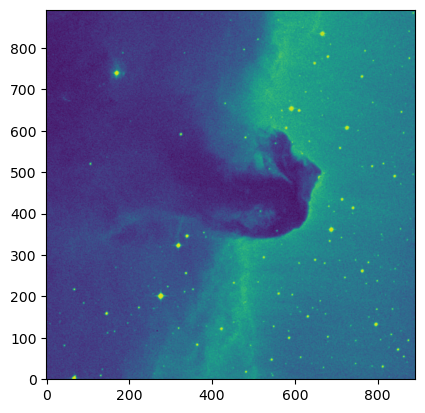

In [346]:
plt.imshow(data, origin='lower')
plt.show()

Let's check that information regarding coordinates exist in the header. We have seen that the list of keywords can sometimes be very long and that it can be tedious to find the keyword of interest. Fortunately, we can filter a bit using `*` to replace characters. Things related to "object" will start with an `O` ... so let's filter this way: 

In [ ]:
header['o*']

Good guess! We see the object RA, DEC are there. But this is not enough, we need to know the complete coordinate transformation system.  
Now, let's check that the coordinate system and transformation (pixels -> physical coordinates) is also defined in the header. 

This information is generally located in cards starting with "C": `CTYPE`, `CRPIX`, `CRVAL`, `CDm_n` rotation matrix... :

In [ ]:
header['c*']

Now that we double-checked all the required info is in the header, let's pass it to `WCS` to instantiate a WCS object. It will then just be a matter of passing the WCS object to `plt.plot` (or `subplot`) through the `projection` argument!

Because the header contains WCS information and acts like a Python dictionary, an Astropy `WCS` object can be created directly from the FITS header.

In [ ]:
w = WCS(header)

All of the information that maps from pixel values to sky coordinates comes from the WCS metadata, which we loaded into the `w` object (from the FITS file header). This `WCS` object is built so that it can be provided to `matplotlib` with the  `projection` keyword, as shown below, in order to produce axes that show sky coordinate information instead of pixel values.

In [ ]:
ax = plt.subplot(projection=w)
ax.imshow(data, origin='lower')
ax.grid(color='white', ls='--')
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
plt.show()

You can check which relevant info from the header was used to create the wcs object, by checking the main axes properties of the newly instantiated WCS object:

In [ ]:
w.get_axis_types

You can overlay a different system of axis coordinates easily with the `ax.get_coords_overlay()` method. Let's illustrate this by overlaying a Galactic coordinate grid:

In [ ]:
ax = plt.subplot(projection=w)
ax.imshow(data, origin='lower')
ax.grid(color='white', ls='-')
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color = 'white', ls=':')
overlay[0].set_axislabel('Galactic longitude')
overlay[1].set_axislabel('Galactic latitude')

plt.show()

You may want to refine a bit the labeling of the axis (let's drop here the galactic coordinates for clarity)

In [ ]:
ax = plt.subplot(projection=w)
ax.imshow(data, origin='lower')
ax.grid(color='white', ls='-')
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')

cRA = ax.coords[0]
cDEC = ax.coords[1]
cRA.set_major_formatter('hh:mm:ss')
cDEC.set_major_formatter('dd:mm:ss')

plt.show()

For more options regarding fine tuning of your grid overlay, you may consult [this page](http://docs.astropy.org/en/stable/visualization/wcsaxes/ticks_labels_grid.html). 

Let's note that there is another powerful (astropy-affiliated) package that allows coordinate overlays with a lot of functionalities: `aplpy`. Its documentation is [here](https://aplpy.readthedocs.io/en/stable/).

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 5.1:** Show an image of the Helix nebula (FITS file `'data/HelixNebula.fits'`) with an appropriate projection and:
1. an RA/Dec grid.
2. a Galactic coordinates grid, instead of the ICRS grid.
</div>

Let's check basic info about the FITS file:

In [358]:
fits.info('data/HelixNebula.fits') # This is a python version of the fitsinfo <filename> command that can be used in terminal

Filename: data/HelixNebula.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     121   (2119, 2119)   int16   


This shows us that our FITS file contains only one extension, labeled 'PRIMARY' (or extension number 0). We will copy the image data from this extension to the variable `helix_img`, and the header data to the variable `helix_head`:

In [ ]:
helix_img, helix_head =

We can print the FITS image header to screen so that all of its contents can be checked or utilized. Note that the WCS information for this information can be found near the bottom of the printed header, below.

In [ ]:
helix_head

Because the header contains WCS information and acts like a Python dictionary, an Astropy `WCS` object can be created directly from the FITS header.

In [ ]:
w_helix =

Let's print the `WCS` object to see what values were drawn from the header.

In [ ]:
w_helix

All of the information that maps from these pixel values to sky coordinates comes from the WCS metadata, which we loaded into the `w_helix` object (from the FITS file header). This `WCS` object is built so that it can be provided to `matplotlib` with the  `projection` keyword, as shown in the call to `matplotlib.pyplot.subplot` below, in order to produce axes that show sky coordinate information instead of pixel values. We will also overlay a coordinate grid in ICRS equatorial coordinates by passing the sky coordinate frame name (here, "icrs") to the `ax.get_coords_overlay()` method.

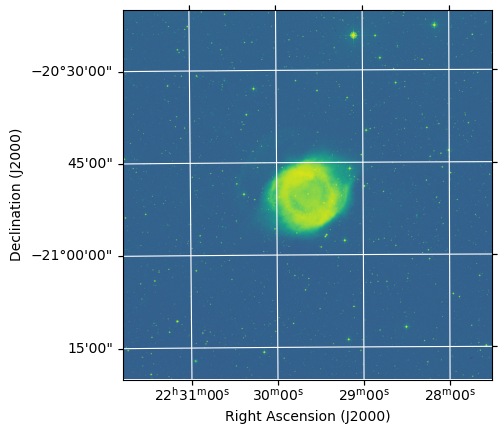

In [ ]:
ax = plt.subplot(projection=)
ax.imshow(helix_img, origin='lower')
ax.grid(color='white', ls='-')
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')

cRA = ax.coords[0]
cDEC = ax.coords[1]
cRA.set_major_formatter('hh:mm:ss')
cDEC.set_major_formatter('dd:mm:ss')

plt.show()

To overlay a Galactic coordinates grid instead:

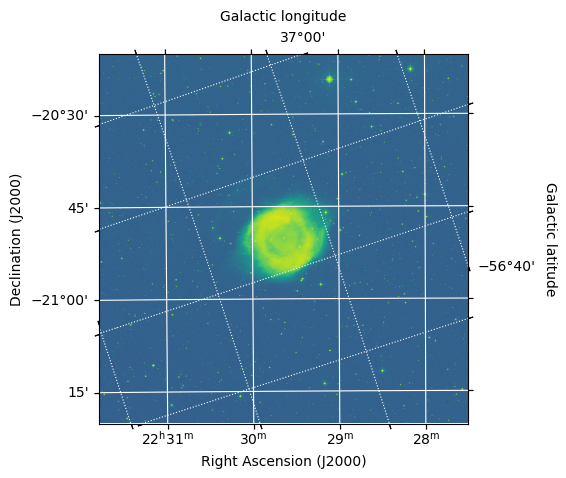

In [ ]:
ax = plt.subplot(projection=)
ax.imshow(helix_img, origin='lower')
ax.grid(color='white', ls='-')
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')

overlay = ax.get_coords_overlay()  # MODIFY the overlay to get also the galactic coordinates 
overlay.grid(color = 'white', ls=':')
overlay[0].set_axislabel('Galactic longitude')
overlay[1].set_axislabel('Galactic latitude')

plt.show()

### 5.2. Basic operations with coordinates

To use those coordinates and calculate e.g. separations between objects, we need to import the `SkyCoord` module from `astropy.coordinates`. In addition, as "coordinates" always have units attached, we need to import `astropy.units` that will allow us to work with "unit-attached quantities".

In [366]:
from astropy.coordinates import SkyCoord
from astropy import units as u

**Coordinates can be instantiated in various ways**, for example giving the coordinates in degree:

In [ ]:
c = SkyCoord(10.625, 41.2, frame='icrs', unit='deg')
c

But you can also explicitly attach the units to your variable using: `u.degree`

In [ ]:
RA, DEC = 10.625*u.degree, 41.2*u.degree
c = SkyCoord(ra=RA, dec=DEC, frame='icrs')

print('(RA, DEC) = ', RA, DEC)
print('c', c)

You have a hard time playing with units in degree? You prefer `hh:mm:ss` / `dd:mm:ss`? No problem:

In [ ]:
c = SkyCoord('00h42.5m', '+41d12m')
c

You can specify your coordinates system using the optional argument `frame`. By default, it considers the ICRS ([International Celestial Reference System](https://en.wikipedia.org/wiki/International_Celestial_Reference_System)) -i.e. this is almost Equatorial J2000. Other valid options for `frame` are 'galactic', 'FK5', etc. 

Note that if you give RA, DEC and specify `frame=galactic`, RA and DEC will be converted and galactic coordinates will be stored. You need to specify arguments `l=my_galactic_longitude, b=my_galactic_latitude` to get the coordinates read as a longitude/latitude.

In [ ]:
c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
print(c)

Yet another possibility is to define the coordinates as follow (single string):

In [ ]:
c = SkyCoord('00 42 30 +41 12 00', unit=(u.hourangle, u.deg))
c = SkyCoord('00:42.5 +41:12', unit=(u.hourangle, u.deg))
c

Once you have a coordinate object you can now access the components of that coordinate (e.g. RA, Dec) and get a specific string representation of the full coordinate.

In [ ]:
c.ra

Conversion is easy:

In [ ]:
c.ra.hour

In [ ]:
c.ra.hms

In [ ]:
c.dec.radian

Coordinates can easily be converted to strings using the `to_string()` method:

In [ ]:
print('c.to_string(\'decimal\') ->', c.to_string('decimal') )
print('c.to_string(\'dms\')     ->', c.to_string('dms') )
print('c.to_string(\'hmsdms\')  ->', c.to_string('hmsdms') )

And if you want to know your coordinates in another coordinate system:

In [ ]:
print(c.galactic )
print('Or with transform_to:')
print(c.transform_to('galactic'))

Transform to 'FK5' and change to get coordinates for an old J1950 equinox. 

In [ ]:
from astropy.coordinates import FK5
c_fk5 = c.transform_to('fk5')
print('coord J2000:', c_fk5)
c_J1950 = c_fk5.transform_to(FK5(equinox='J1950'))  # precess to a different equinox 
print('coord, J1950', c_J1950)

### 5.3. Conversion between image and world coordinates

Let's now see how to overlay a symbol on an image at a specific position.    
Let's work with the image of the Horse Head nebula again. Remember that we did:
``` python
image_data, header = fits.getdata(image_file, header=True)
w = WCS(header)
```

In [ ]:
plt.imshow(image_data, cmap='gray', origin='lower')

Let's define some pixel coordinates of interest (remember the y coordinate comes first), as read from the images. FITS standard is 1-based and the x-axis comes before the y-axis (unlike Numpy - although we use a numpy array to store these pairs of coordinates!)

In [389]:
pixcrd = np.array([[500, 300],  #x1, y1
                   [224, 438]]) #x2, y2

Let's plot them:

In [ ]:
plt.imshow(image_data, cmap='gray', origin='lower')
plt.plot(pixcrd[0,0], pixcrd[0,1], 'd', color='green')
plt.plot(pixcrd[1,0], pixcrd[1,1], 'x', color='red')

Let's now convert them to world coordinates:

In [ ]:
world = w.wcs_pix2world(pixcrd, 1)
print(world)

The second argument is "origin" -- in this case we're declaring we have 1-based (Fortran-like) coordinates (because this is also the FITS standard definition in the header - ref pixels are never 0).

You can now convert those coordinates into `SkyCoord` instances:

In [ ]:
world_SC = [SkyCoord(wc[0], wc[1], unit='deg') for wc in world]
world_SC

You can also measure the separation between those two pixels ... 

In [ ]:
world_SC[0].separation(world_SC[1])

... and convert this into arcseconds. 
The separation is an angle and you can convert it to other angular units using the method `to(newunits)`:

In [ ]:
world_SC[0].separation(world_SC[1]).to(u.arcsec)

Now you can also overlay those 2 pixels on your image (you simply have to give their pixel coordinates ... nothing fancy in there !).

Conversely, you may want to see to which pixel corresponds a specific coordinate. For that you need to use a `wcs.WCS` method to convert a coordinate into pixel. 

To illustrate the latter, let's consider the new RA/DEC coordinates for the first pixel, and double-check we recover the original pixel coordinates:

In [ ]:
print(world_SC[0].ra.value, world_SC[0].dec.value)

w.wcs_world2pix(world_SC[0].ra.value,
                world_SC[0].dec.value,
                1) # again 1 is here to fix the origin of the coordinate system

This is indeed the case.

Let's now define a new set of RA / DEC coordinates and plot a marker there:

In [ ]:
w = WCS(header)

# image plot parameters
ax = plt.subplot(projection=w)
ax.imshow(image_data, origin='lower')
ax.grid(color='white', ls='solid')
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')

# define markers
mrk = ['x', 'd']
[ax.plot(px[0], px[1], marker=mrk[i], color='red') for i, px in enumerate(pixcrd)]

# Let's define another point in RA/DEC coordinates, convert it to pixel coordinates, and plot it.
newpx = w.wcs_world2pix(85.2296, -2.4434, 1)
print(newpx)
ax.plot(newpx[0], newpx[1], marker='o', color='orange')

plt.show()

### 5.4. Spherical projections

For this exercice, let's consider the coordintes in the file `'data/Young-Objects-Compilation.csv'`, which have previously loaded. The file contains a compilation of young objects, their coordinates and some properties, including measured magnitudes in different bands.

Let's first load the information in the file in an Astropy Table (as before):

In [400]:
data = Table.read("data/Young-Objects-Compilation.csv", header_start=1, data_start=2)

Let's fill the missing data with Nan values:

In [ ]:
data['RA'].filled(np.nan)

Next we want to plot the coordinates of the sources in the catalog on some 2D projection of the sky. Let's consider the Mollweide projection.

We start by creating a `Figure` object, adding a single subplot to the
figure, and specifying a projection with the `projection` keyword.

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
plt.plot()

The axis object, `ax`, knows to expect angular coordinate
values. An important fact is that it expects the values to be in
_radians_, and it expects the azimuthal angle values to be between
(-180º,180º). This is (currently) not customizable, so we have to
coerce our RA data to conform to these rules!

`astropy` provides a
coordinate class for handling angular values, `astropy.coordinates.Angle`. 
We can convert our column of RA values to radians using this class.

In [403]:
import astropy.coordinates as coord

ra = coord.Angle(data['RA'].filled(np.nan)*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(data['Dec'].filled(np.nan)*u.degree)

Now let's plot the data as a scatter plot:

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian)
plt.plot()

By default, matplotlib will add degree tick labels, so let's change the
horizontal (x) tick labels to be in units of hours, and display a grid:

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.plot()

We can save this figure as a PDF using the `savefig` function:

In [406]:
fig.savefig("figures/map.pdf")

Let's now make the map again, but with each of the following **projections**: `aitoff`, `hammer`, `lambert`, and `None` (which is the same as not giving any projection). 

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(ra.radian, dec.radian)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.plot()

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="hammer")
ax.scatter(ra.radian, dec.radian)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.plot()

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="lambert")
ax.scatter(ra.radian, dec.radian)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.plot()

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)    #  we did not set any projection 
ax.scatter(ra.radian, dec.radian)  
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.plot()

### 5.5. Scale marker (FYI)

Another application of WCS is to plot a scale marker on your images.

To add a scale marker (i.e., a line of a particular *angular* size), we will use the matplotlib `Axes.arrow` method to draw a line. We then use the `transform` attribute of `Axes.arrow` to draw scale bars in degrees (instead of pixel coordinates).

**Example:** Let's consider the case of adding a scale marker of 0.1 degree on the Helix nebula image. Let's start by loading the image from the FITS file:

In [412]:
helix_image, helix_header = fits.getdata("data/HelixNebula.fits", header=True)

Let's (re)instantiate the WCS object associated to the Helix nebula image:

In [ ]:
wcs_helix = WCS(helix_header)
wcs_helix

Next, we need to decide where to place the scale bar. Let's define the center of the scale marker to be at `(RA, Dec) = (337 deg, -21.2 deg)`:

In [414]:
RA_marker = 337.
DEC_marker = -21.2

We then use the `transform` attribute of `Axes.arrow` to draw our scale bars in degrees (instead of pixel coordinates). In this case, we draw a scale marker with a length of 0.1 degrees. The arrow method inputs are `ax.arrow(x, y, dx, dy, **kwargs)`, with `x` and `y` being the `RA` and `Dec` of the beginning of the line.

We use `dx=0` so that there is no horizontal component in the bar, and `dy=0.1`, which gives the length of the arrow in the vertical direction. To ensure that the arrow is drawn in the J2000 ICRS coordinate frame, we pass `ax.get_transform('icrs')` to the `transform` keyword.

Finally, we use `matplotlib.pyplot.text` to mark the length of the scale marker.

In [ ]:
fig = plt.figure(figsize=(10, 10), frameon=False)
ax = plt.subplot(projection=wcs_helix)
ax.arrow(RA_marker, DEC_marker, dx=0, dy=0.1, 
         head_width=0, head_length=0, 
         fc='white', ec='white', width=0.003, 
         transform=ax.get_transform('icrs'))
plt.text(RA_marker+0.05, DEC_marker+0.02, '0.1 deg',  # shift text a little bit
         color='white', rotation=90, 
         transform=ax.get_transform('icrs'))
plt.imshow(helix_image, origin='lower', cmap='cividis', aspect='equal')
plt.xlabel(r'RA')
plt.ylabel(r'Dec')
plt.plot()

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 5.3:** Make a horizontal bar with a length of 5 arcmin. Keep in mind that 1 arcmin = 1/60 deg (not 1/60 hour angle)... or use astropy `Angle`.
</div>

In [416]:
from astropy.coordinates import Angle
dx = Angle(5 * u.arcmin).deg

In [ ]:
fig = plt.figure(figsize=(10, 10), frameon=False)
ax = plt.subplot(projection=wcs_helix)
ax.arrow(RA_marker, DEC_marker, dx=dx, dy=0, 
         head_width=0, head_length=0, 
         fc='white', ec='white', width=0.003, 
         transform=ax.get_transform('icrs'))
plt.text(RA_marker+0.6*dx, DEC_marker+0.02, "5'",  # shift text a little bit
         color='white', #rotation=90, 
         transform=ax.get_transform('icrs'))
plt.imshow(helix_image, origin='lower', cmap='cividis', aspect='equal')
plt.xlabel(r'RA')
plt.ylabel(r'Dec')

### 5.6. 3D sky coordinates

`SkyCoord` objects can accept a `distance` argument, to effectively turn them into 3D sky coordinates. For a lot of objects, distances can be retrieved through the measured parallax in the Gaia archive.

**Example:** Let's say you want to gather a table with magnitude properties for all stars within the NGC 188 open cluster (assume they are located within 5deg from the center of the cluster) that are observable with a given instrument. Let's assume the sensitivity of that instrument within a given integration time corresponds a magnitude G < 19.

Let's start by retrieving the (2D) sky coordinates of NGC 188, by querying Simbad through astroquery:

In [ ]:
from astroquery.simbad import Simbad

result_table = Simbad.query_object("NGC 188")
print(result_table)

In [420]:
ra_ngc188 = result_table['ra'][0]
dec_ngc188 = result_table['dec'][0]

Let's now make a SkyCoord object:

In [ ]:
ngc188_center = SkyCoord(ra_ngc188, dec_ngc188, frame='icrs', unit=(u.hourangle, u.deg))
ngc188_center

**Alternatively**, one could have done this in one line with `SkyCoord.from_name`, which calls Simbad undercover:

In [ ]:
ngc188_center = SkyCoord.from_name('NGC 188')
ngc188_center

Let's now query the Gaia archive through `astroquery`, and make a cone search of all objects within 5 deg of the center - i.e. to capture all stars that might be members of the star cluster. More details on how to query the Gaia archive through `astroquery` [here](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html).

In [ ]:
from astroquery.gaia import Gaia
Gaia.ROW_LIMIT = 10000  # Set the row limit for returned data

In [424]:
job = Gaia.cone_search_async(ngc188_center, radius=0.5*u.deg)
ngc188_table = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


This is an Astropy Table:

In [ ]:
type(ngc188_table)

We can easily filter out targets fainter than G = 19.

In [426]:
ngc188_table = ngc188_table[ngc188_table['phot_g_mean_mag'] < 19*u.mag]

In [ ]:
ngc188_table

Let's define the columns we are interested in:

In [430]:
cols = [
    'source_id',
    'ra',
    'dec',
    'parallax',
    'parallax_error',
    'pmra',
    'pmdec',
    'radial_velocity',
    'phot_g_mean_mag',
    'phot_bp_mean_mag',
    'phot_rp_mean_mag'
]

Let's write these columns in a new table - to avoid having to carry out the search again:

In [431]:
ngc188_table[cols].write('outputs/gaia_results.fits', overwrite=True)

Let's read the table:

In [432]:
from astropy.table import QTable
ngc188_table = QTable.read('outputs/gaia_results.fits')

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side Note:** The **QTable** class is identical to **Table** except that columns with an associated unit attribute are converted to Quantity objects.
</div>

Let's check the number of objects in the table:

In [ ]:
len(ngc188_table)

The returned `astropy.table` `Table` object now contains about 5000 stars from *Gaia* DR2 around the coordinate position of the center of NGC 188. But this does not mean they are all part of the open cluster - some may be foreground/background stars.

Let's now construct a `SkyCoord` object with the results table. In the *Gaia* data archive, the ICRS coordinates of a source are given as column names `"ra"` and `"dec"`:

In [ ]:
ngc188_table['ra']

In [ ]:
ngc188_table['dec']

As can be seen above, RA and DEC are quantities. Which makes the definition of a `SkyCoord` object straightforward:

In [ ]:
ngc188_gaia_coords = SkyCoord(ngc188_table['ra'], ngc188_table['dec'])
ngc188_gaia_coords

So far, we have used `SkyCoord` to represent angular sky positions (i.e., `ra` and `dec` only). It is sometimes useful to include distance information with the sky coordinates of a source, thereby specifying the full 3D position of an object. To pass in distance information, `SkyCoord` accepts the keyword argument "`distance`". So, if we knew that the distance to NGC 188 is 1.96 kpc, we could also pass in a distance (as a `Quantity` object) using this argument:

In [437]:
ngc188_center_3d = SkyCoord(12.11*u.deg, 85.26*u.deg,
                            distance=1.96*u.kpc)

With the *Gaia* table retrieved above for stars around NGC 188, `ngc188_table`, we also have a parallax measurement for each star. For a precisely-measured parallax $\varpi$, the distance $d$ to a star can be obtained approximately as $d \approx 1/\varpi$. This only really works if the parallax error is small relative to the parallax ([see discussion in this paper](https://arxiv.org/abs/1507.02105)), so if we want to use these parallaxes to get distances we first have to filter out stars that have large uncertainties on their parallaxes, or in other words low signal-to-noise parallaxes:

In [ ]:
parallax_snr = ngc188_table['parallax'] / ngc188_table['parallax_error']
ngc188_table_3d = ngc188_table[parallax_snr > 10] 
len(ngc188_table_3d)

The above selection on `parallax_snr` keeps stars that have a ~10-sigma parallax measurement, but this is an arbitrary selection threshold that you may want to tune or remove in your own use cases. This selection removed over half of the stars in our original table, but for the remaining stars we can be confident that converting the parallax measurements to distances is mostly safe.

The default way of passing in a distance to a `SkyCoord` object, as above, is to pass in a `Quantity` with a unit of length. However, `astropy.coordinates` also provides a specialized object, `Distance`, for handling common transformations of different distance representations ([docs](http://docs.astropy.org/en/latest/coordinates/index.html#distance)). Among other things, this class supports passing in a parallax value:

In [ ]:
from astropy.coordinates import Distance
Distance(parallax=1*u.mas)

The catalog of stars we queried from *Gaia* contains parallax information in milliarcsecond units, so we can create a `Distance` object directly from these values:

In [440]:
gaia_dist = Distance(parallax=ngc188_table_3d['parallax'].filled(np.nan))

We can then create a `SkyCoord` object to represent the 3D positions of all of the *Gaia* stars by passing in this distance object to the `SkyCoord` initializer:

In [ ]:
ngc188_coords_3d = SkyCoord(ra=ngc188_table_3d['ra'], 
                            dec=ngc188_table_3d['dec'],
                            distance=gaia_dist)
ngc188_coords_3d

Let's now use `matplotlib` to plot the sky positions of all of these sources, colored by distance to emphasize the cluster stars:

In [ ]:
fig, ax = plt.subplots(figsize=(6.5, 5.2),
                       constrained_layout=True)
cs = ax.scatter(ngc188_coords_3d.ra.degree, 
                ngc188_coords_3d.dec.degree, 
                c=ngc188_coords_3d.distance.kpc, 
                s=5, vmin=1.5, vmax=2.5, cmap='twilight')
cb = fig.colorbar(cs)
cb.set_label(f'distance [{u.kpc:latex_inline}]')

ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

ax.set_title('Gaia DR2 sources near NGC 188', fontsize=18)

Now that we have 3D position information for both the cluster center, and for the stars we queried from *Gaia*, we can compute the 3D separation (distance) between all of the *Gaia* sources and the cluster center:

In [ ]:
sep3d = ngc188_coords_3d.separation_3d(ngc188_center_3d)
sep3d

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 5.4:** Using the 3D separation values, define a boolean mask to select candidate members of the cluster. Select all stars within 50 pc of the cluster center. How many candidate members of NGC 188 do we have, based on their 3D positions? What is the fraction of membership compared to all candidates with G<19 within 0.5 deg of the cluster center?
</div>

In [ ]:
ngc188_3d_mask =    # Create a mask based on sep3d to select objects within 50 pc from the cluster center
print('There are %i objects wihtin 50 pc from the cluster center' % len(sep3d[ngc188_3d_mask]))

In [ ]:
n_members = np.sum(ngc188_3d_mask) # alternative way to estimate number of members 
n_members

In [ ]:
print('Fraction of members within 50 pc from the cluster center: %.2f' % (), "%")

Fraction of members within 50 pc from the cluster center: 10.81 %


<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 5.5:**

**a)** Determine the median distance of the Pleiades, assuming that it can be estimated as the median distance of the 9 brightest stars (in V mag) within 50 arcmin of its center (as returned with `SkyCoord.from_name` from `astropy.coordinates`).

**b)** Make a scatter plot of all objects with G magnitude brighter than 10 within 1 deg of the center of the Pleiades, that is color-coded by distance.

**c)** Make an Astropy Table listing all stars in the Pleiades that can be observed with binoculars in good observing conditions (G mag brigther than 10). Assume that the volume of the Pleiades is contained within a radius of ~12 pc of the median distance you found above. Include the following columns: source ID, RA, DEC, parallax, distance, G magnitude. Save the table in a FITS file.

---

Tip 1: Use the Gaia archive for distances, as done previously. The 'phot_g_mean_mag' column provides the G band magnitude. Only consider rows with values for both parallax and G mag (use the `.mask` attribute if needed).

Tip 2: For exercice a), use the [Tycho-2 catalogue](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/259/tyc2&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa) for V magnitudes ('VTmag' column), and the X-match utility of `astroquery` as in [Sec. 2.3](#2.3.-Retrieving-data-from-a-Vizier-catalog).

Tip 3: `table.add_index['<column_name>']` defines an index to automatically sort your table based on the values in that column. Use `table.iloc[index]` to then parse it.
</div>

**a)**

In [ ]:
pleiades_center = SkyCoord.from_name("Pleiades")
pleiades_center

In [475]:
Gaia.ROW_LIMIT = 100000 # set the maximum number of rows for your search

In [ ]:
job = # run the search
pleiades_candidates_table = job.get_results() # load the results of the search

In [ ]:
pleiades_candidates_table

In [ ]:
from astroquery.xmatch import XMatch

tableX = XMatch.query(cat1=pleiades_candidates_table,
                      cat2='',  # Add id of the Tycho2 catalog
                      max_distance = 1 * u.arcsec,    # match between gaia and tycho2 
                      colRA1='ra',
                      colDec1='dec')

In [ ]:
type(tableX), len(tableX)

In [ ]:
tableX

In [ ]:
# Search for the 9 brightest stars with parallax in that table 

In [ ]:
brightest9_stars = 
med_parallax = 
med_dist = Distance(parallax=med_parallax)
print(med_parallax, ' - median Distance = %.2f pc' %(med_dist.pc))

**b)**

In [ ]:
# Get the G-mag of the stars within 1 deg from the Pleiades center
job = Gaia.cone_search_async(pleiades_center, radius=1*u.deg)
pleiades_candidates_table = job.get_results()

In [ ]:
# Get the stars brighter than G = 10 mag 


In [ ]:
# Get the parallax of those stars 


In [ ]:
# Calculate distances based on the parallaxes 

Text(0.5, 1.0, 'Gaia DR2 sources in or near Pleiades')

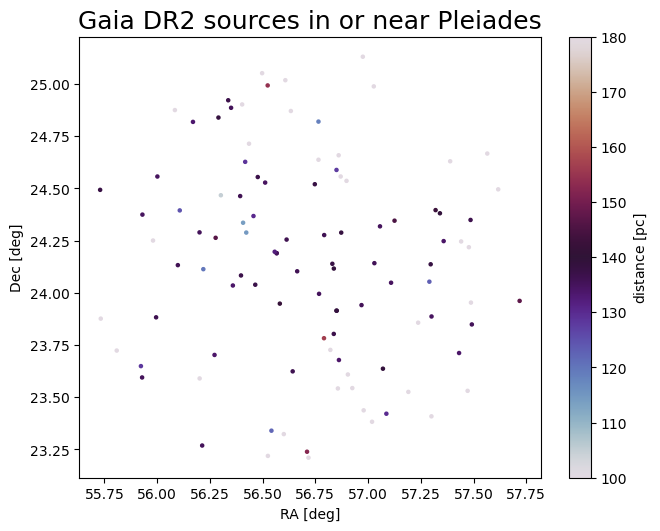

In [ ]:
# Figure template to display the results
fig, ax = plt.subplots(figsize=(6.5, 5.2),
                       constrained_layout=True)
cs = ax.scatter(np.array(pleiades_coords_3d.ra)*u.degree, 
                np.array(pleiades_coords_3d.dec)*u.degree, 
                c=np.array(pleiades_coords_3d.distance)*u.pc, 
                s=5, vmin=100, vmax=180, cmap='twilight')
cb = fig.colorbar(cs)
cb.set_label(f'distance [{u.pc:latex_inline}]')

ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

ax.set_title('Gaia DR2 sources in or near Pleiades', fontsize=18)

**c)** Make an Astropy Table listing all stars in the Pleiades that can be observed with binoculars in good observing conditions (G mag brigther than 10). Assume that the volume of the Pleiades is contained within a radius of ~12 pc of the median distance you found above. Include the following columns: source ID, RA, DEC, parallax, distance, G magnitude. Save the table in a FITS file.

In [ ]:
pleiades_center_3d = SkyCoord(ra=pleiades_center.ra,
                              dec=pleiades_center.dec,
                              distance=med_dist
                             )
pleiades_center_3d

In [ ]:
sep3d = 

In [ ]:
len(sep3d)

In [558]:
from astropy.table import QTable

# source ID, RA, DEC, parallax, distance, G magnitude
candidate_table = QTable([parallax_defined_candidates['source_id'],
                          parallax_defined_candidates['ra'],
                          parallax_defined_candidates['dec'],
                          parallax_defined_candidates['parallax'],
                          Distance(parallax=parallax_defined_candidates['parallax']),
                          sep3d,
                          parallax_defined_candidates['phot_g_mean_mag']],
                         names=('star name', 'RA', 'DEC', 'parallax', 'distance', '3D separation', 'G magnitude') 
                         )

In [ ]:
candidate_table

In [ ]:
final_table = candidate_table[] # Use a mask to select only the stars of interest (12 pc volume around the  center))
final_table

In [ ]:
# Command to write your final table into a file  

## References

- This notebook is mostly based on the astropy tutorials available [here](https://learn.astropy.org/).
- Your reference for using `astropy` should be the [online documentation](http://docs.astropy.org/en/latest). Here are links to specific documentation on [quantities](https://docs.astropy.org/en/stable/units/index.html), [constants](https://docs.astropy.org/en/stable/constants/index.html), the [`wcs` module](http://docs.astropy.org/en/stable/visualization/wcsaxes/), [FITS handling](https://docs.astropy.org/en/stable/io/fits/index.html), [`coordinates`](http://docs.astropy.org/en/stable/coordinates/index.html), [`Table` objects](http://docs.astropy.org/en/stable/table/io.html), and [modeling](https://docs.astropy.org/en/stable/modeling/index.html).
- Astroquery documentation on [cross-matching](https://docs.astropy.org/en/stable/modeling/index.html)
- Pandas documentation on [DataFrames](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html#dataframe)
- How bad is your color map ? (aka how not to be fooled by a poor choice of color map): https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/


## Credits:

If you use Astropy directly—or as a dependency to another package—for your work, please remember to include the following acknowledgment at the end of papers:

*This research made use of Astropy, a community-developed core Python package for Astronomy (Astropy Collaboration, 2013).*

Where the astropy paper is 2013, A&A, 558, 33 http://adsabs.harvard.edu//abs/2013A%26A...558A..33A

[Go back to top](#Table-of-contents)